# W207- Applied Machine Learning - Section 1

## Title: Random Acts of Pizza

## Team 2: Sartaj Singh Baveja, Tim Spittle, Jay Venkata & Angela Wu

**Table of Contents**

1. [Overview](#overview)
2. [Data Preparation](#dataprep)  
2.1 [Initial Loading](#loading)  
3. [Exploratory Data Analysis](#eda)  
3.1 [Features of Interest](#featinterest)  
3.2 [Variable correlation plot](#corrplot)  
3.3 [Request Time Variables](#time)  
3.4 [Requester Profile Variables](#profile)  
3.5 [Textual Features](#textual)  
4. [Baseline Model](#baseline)  
4.1 [ZeroR Baseline](#bzeroR)  
4.2 [NaiveBayes Baseline](#bnb)  
4.3 [Logistic Regression Baseline](#blr)  
4.4 [XGBoost Baseline](#bxg)  
5. [Feature Engineering](#featengg)  
5.1 [Time](#fe_time)  
5.2 [Requester Profile Variables](#fe_reqprofile)  
5.3 [Textual Features](#fe_textual)  
6. [Model Selection](#models)  
6.1 [Naive Bayes Model](#mnb)  
6.2 [Logistic Regression model](#mlr)  
6.3 [XGBoost Model](#mxg)  
6.4 [Model Tuning](#tuning)  
7. [Error Analysis](#error)
8. [Conclusion](#conclusion)

<a id="overview"></a>

## 1. Overview

This competition contains a dataset with textual requests for pizza from the Reddit community - Random Acts of Pizza (https://www.reddit.com/r/Random_Acts_Of_Pizza/) together with their outcome (successful/unsuccessful) and meta-data. 

The dataset includes 5671 requests collected from the Reddit community between December 8, 2010 and September 29, 2013 (retrieved on September 30, 2013). All requests ask for the same thing: a free pizza. The outcome of each request i.e whether its author received a pizza or not, is known. Meta-data includes information such as: time of the request, activity of the requester, community-age of the requester, etc.  

**Outcome of Project**: By getting a sense of the dynamics and factors of a request that most likely would influence its success, the team hopes to build a model capable of predicting which requests will garner a cheesy (but sincere!) act of kindness and will result in a pizza purchase.

<a id="dataprep"></a>

## 2. Data Preparation

In [137]:
import sys
# !{sys.executable} -m pip install wordcloud
# !{sys.executable} -m pip install nltk
# !{sys.executable} -m pip install xgboost
# !{sys.executable} -m pip install graphviz
# !{sys.executable} -m conda install graphviz
# !{sys.executable} -m pip install pyenchant

In [138]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import json
import os
from pprint import pprint
import pandas as pd
import re
## Reference: https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import time
import datetime
import scipy.stats as stat
import string
import warnings

# SK Learn Libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import *
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.sparse import hstack
from sklearn.feature_selection import SelectFromModel

# https://xgboost.readthedocs.io/en/latest/index.html
import xgboost as xgb

# Source : https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
# NMF (Non-Negative Matrix Factorization) to understand topic breakdown
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

### New packages
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn'

[nltk_data] Downloading package punkt to /Users/ssbaveja/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ssbaveja/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ssbaveja/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Each entry in pizza_request_dataset.json corresponds to one request (the first and only request by the requester).

### Fields in each request

| Field Name | Description |
| ---------- | ----------- |
| giver_username_if_known | Reddit username of giver if known, i.e. the person satisfying the request ("N/A" otherwise). |
| in_test_set | Boolean indicating whether this request was part of our test set. |
| number_of_downvotes_of_request_at_retrieval | Number of downvotes at the time the request was collected. |
| number_of_upvotes_of_request_at_retrieval | Number of upvotes at the time the request was collected. |
| post_was_edited | Boolean indicating whether this post was edited (from Reddit). |
| request_id | Identifier of the post on Reddit, e.g. "t3_w5491". |
| request_number_of_comments_at_retrieval | Number of comments for the request at time of retrieval. |
| request_text | Full text of the request. |
| request_text_edit_aware | Edit aware version of "request_text". We use a set of rules to strip edited comments indicating the success of the request such as "EDIT: Thanks /u/foo, the pizza was delicous". |
| request_title | Title of the request. |
| requester_account_age_in_days_at_request | Account age of requester in days at time of request. |
| requester_account_age_in_days_at_retrieval | Account age of requester in days at time of retrieval. |
| requester_days_since_first_post_on_raop_at_request | Number of days between requesters first post on RAOP and this request (zero if requester has never posted before on RAOP). |
| requester_days_since_first_post_on_raop_at_retrieval | Number of days between requesters first post on RAOP and time of retrieval. |
| requester_number_of_comments_at_request | Total number of comments on Reddit by requester at time of request. |
| requester_number_of_comments_at_retrieval | Total number of comments on Reddit by requester at time of retrieval. |
| requester_number_of_comments_in_raop_at_request | Total number of comments in RAOP by requester at time of request. |
| requester_number_of_comments_in_raop_at_retrieval | Total number of comments in RAOP by requester at time of retrieval. |
| requester_number_of_posts_at_request | Total number of posts on Reddit by requester at time of request. |
| requester_number_of_posts_at_retrieval | Total number of posts on Reddit by requester at time of retrieval. |
| requester_number_of_posts_on_raop_at_request | Total number of posts in RAOP by requester at time of request. |
| requester_number_of_posts_on_raop_at_retrieval | Total number of posts in RAOP by requester at time of retrieval. |
| requester_number_of_subreddits_at_request | The number of subreddits in which the author had already posted in at the time of request. |
| requester_received_pizza | Boolean indicating the success of the request, i.e., whether the requester received pizza. |
| requester_subreddits_at_request | The list of subreddits in which the author had already posted in at the time of request. |
| requester_upvotes_minus_downvotes_at_request | Difference of total upvotes and total downvotes of requester at time of request. |
| requester_upvotes_minus_downvotes_at_retrieval | Difference of total upvotes and total downvotes of requester at time of retrieval. |
| requester_upvotes_plus_downvotes_at_request | Sum of total upvotes and total downvotes of requester at time of request. |
| requester_upvotes_plus_downvotes_at_retrieval | Sum of total upvotes and total downvotes of requester at time of retrieval. |
| requester_user_flair | Users on RAOP receive badges (Reddit calls them flairs) which is a small picture next to their username. In our data set the user flair is either None (neither given nor received pizza, N=4282), "shroom" (received pizza, but not given, N=1306), or "PIF" (pizza given after having received, N=83). |
| requester_username | Reddit username of requester. |
| unix_timestamp_of_request | Unix timestamp of request (supposedly in timezone of user, but in most cases it is equal to the UTC timestamp -- which is incorrect since most RAOP users are from the USA). |
| unix_timestamp_of_request_utc | Unit timestamp of request in UTC. |

<a id="loading"></a>

### 2.1 Initial Loading

In [139]:
## Load the training data in JSON
with open(os.path.join(os.getcwd(), 'train.json')) as org_train_data_file:    
    org_train_data = json.load(org_train_data_file)

## Load the test data in JSON
with open(os.path.join(os.getcwd(), 'test.json')) as org_test_data_file:    
    org_test_data = json.load(org_test_data_file)

In [140]:
# Convert the training data in JSON to pandas dataframe
org_train_df_raw = pd.io.json.json_normalize(org_train_data)
org_train_df = pd.DataFrame.from_records(org_train_data)

Then, we split our data into training and development. Further, we make sure that both sets mirror the average success rate in our dataset of 24.6%

In [141]:
## Split the original training data into training and development
np.random.seed(0)
train_df, dev_df = train_test_split(org_train_df, test_size = 0.4, stratify = org_train_df['requester_received_pizza'])

train_labels = train_df.requester_received_pizza.astype(int).values
dev_labels = dev_df.requester_received_pizza.astype(int).values

## Verify the stratefication works
print("Sucess Rate (training data): " + str(round(train_df["requester_received_pizza"].mean(),2)))
print("Sucess Rate (dev data): " + str(round(dev_df["requester_received_pizza"].mean(),2)))

Sucess Rate (training data): 0.25
Sucess Rate (dev data): 0.25


Lastly we review overlap of variables in train data that are also available in test data.

In [142]:
# Convert the test data in JSON to pandas dataframe
test_df = pd.DataFrame.from_records(org_test_data)

In [143]:
train_columns = list(train_df.columns.values)
test_columns = list(test_df.columns.values)

var_table_overlap = pd.DataFrame(columns = ['Variable', 'Train', 'Test'])
train_var_series = pd.Series(train_columns, name='Variable')

test_var_series = train_var_series.isin(test_columns)
var_table_overlap['Variable'] = train_columns
var_table_overlap['Train'] = True
var_table_overlap['Test'] = test_var_series
var_table_overlap.sort_values(by = ['Test'])

,Variable,Train,Test
10,requester_account_age_in_days_at_retrieval,True,False
18,requester_number_of_posts_at_retrieval,True,False
22,requester_received_pizza,True,False
16,requester_number_of_comments_in_raop_at_retrieval,True,False
14,requester_number_of_comments_at_retrieval,True,False
12,requester_days_since_first_post_on_raop_at_ret...,True,False
25,requester_upvotes_minus_downvotes_at_retrieval,True,False
27,requester_upvotes_plus_downvotes_at_retrieval,True,False
20,requester_number_of_posts_on_raop_at_retrieval,True,False
6,request_text,True,False


From the above, we only focus on the columns that are present in both the datasets and disregard the others. This is because of the following reasons. The variable names ending in *_at_retrieval_* don't relate to the concept of real-time as much as those ending in *_at_request_*. Further, the *user_flair* variable isn't relevant to us since this is captured after the *received_pizza* variable. Also, the variables *post_was_edited* and *request_text* are less important compared to the *request_text_edit_aware* variable since this captures the edit aware version of "request_text" and uses a set of rules to strip edited comments indicating the success of the request. Finally, the *requester_received_pizza* variable is our outcome variable that needs to be predicted.

<a id="eda"></a>  
## 3. Exploratory Data Analysis  

<a id="featinterest"></a>  
**NOTE:** Removed data cleaning section - decided against removnig outliers since feature creation makes the continuous outlier less of an issue. Rolled variable conversion into the remaining code.

### 3.1 Features of Interest

Success of these reddit requests depend on factors like who is asking, how they are asking, and when are they asking. This will help us understand the attributes of the best formulated requests and why certain ones are promoted higher than others.

#### Meta-Data Features

_General Note_ Many features not present in test data are not known at time of posting, therefore they will be ignored for this analysis. This includes the "at retrieval" statistics, RAOP "user flair", and raw (i.e. non-"edit aware") request text.  

**Request Time**  
Time is a very basic but important feature to include. Logically, there are likely times of day when more users are active on RAOP and this may have varied effects on the behaviors we observe:  
- More users requesting may make the environment more competitive (i.e. harder for a single post to stand out) 
- Conversely, more users giving may make likelihood of success higher (all things equal).  

These periods of increased requests/gives may not coincide with one another and it will be important to understand the periods of high and low activity relative to UTC; there may be multiple shifts throughout a day coinciding with higher activity in different countries/time zones around the globe.

**Requester Profile**    
In attempting to predict likelihood of fulfillment for a request on RAOP based on featues related to the profile of the requester, we believe it may be important to make a distinction between: 
- _Primary_ profile features (i.e. features which an average reader/potential giver on RAOP may see/consider)
    - Age of account - whether it appears to be a new/throwaway account or a longtime veteran  
    - Number and frequency of requests - if the requester has made requests before
- _Secondary_ features (i.e. extended detail about requester activity on Reddit that a potential giver might not see, and therefore it wouldn't have as much influence on their likelihood of fulfilling the request or not)  
    - Comments made
    - Posts
    - Sub-Reddits in which they participate
    - Upvotes/Downvotes

**Community Effects (Secondary)**  
The training data constrains featues related to the reactions to a request on RAOP (upvotes/downvotes/comments) which, while not available in the test data and not appropriate for success classifcation algorithm (given that we don't know this info at time of the request nor do we know if this activity happened before/after the request was fulfilled), positive or contentious reactions to posts may be correlated with success/fulfillment. Therefore, it may be worhtwhile to explore these relationships and, if useful, a sensitivity analysis that predicts these metrics to provide additional insight into predictive features.  


#### Textual Data Features

Each textual post contains a story behind the post and the reasoning behind the free pizza request. With techniques such as topic modelling it is possible to extract the theme or narrative behind most of these posts. 
In addition to evaluating the role of the length of the post, it is also possible to visualize the most common bigrams and unigrams within both successful and unsuccessful request posts 

<a id="corrplot"></a>  
### 3.2 Variable correlation plot  

First, let's take a look at a variable correlation plot that helps us better understand the relationship between the features and whether or not a request is fulfilled

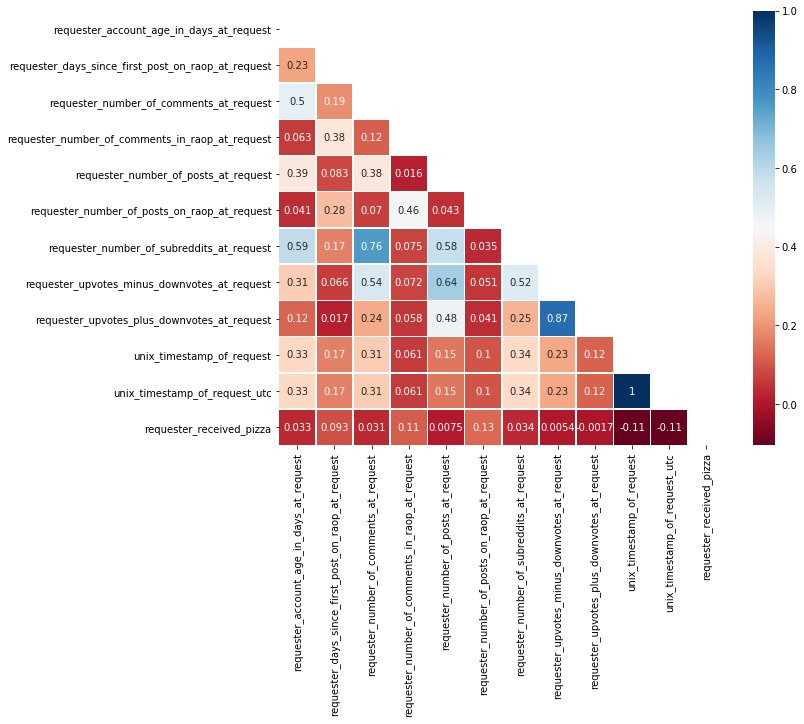

In [144]:
# Create new dataframe with only the shared columns
train_align_test = train_df[test_df.columns.values]
dev_align_test = dev_df[test_df.columns.values]

# Add back outcome variable
train_align_test['requester_received_pizza'] = train_df['requester_received_pizza']
dev_align_test['requester_received_pizza'] = dev_df['requester_received_pizza']

# Calculate and plot correlation matric
f, ax = plt.subplots(figsize=(10, 8))
corr = train_align_test.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, 
            mask=mask, 
            cmap="RdBu",
            annot=True,
            linewidth=0.5)

From the above correlation matrix, we can see that the unix_timestamp_of_request and unix_timestamp_of_request_utc are perfectly correlated as expected. Further, we see that the requester_upvotes_plus_downvotes_at_request seems to be highly correlated to requester_upvotes_minus_downvotes_at_request. The requester_upvotes_minus_downvotes_at_request variable shows strong correlation with requester_number_of_comments_in_raop_at_request, requester_number_of_posts_on_raop_at_request and requester_number_of_subreddits_at_request.


Upon taking a look at the last row, we can see how the features are correlated to our outcome variable, *requester_received_pizza*. The striking factor is that there is no clear strong correlation that can be seen. All of the variables are weakly correlated with our outcome variable. Among these variables, the following features seem to be most correlated and could be features to include when training our model: requester_number_of_posts_on_raop_at_request, requester_number_of_comments_in_raop_at_request and requester_days_since_first_post_on_raop_at_request

<a id="time"></a>  
### 3.3 Request Time Variables

Let's break down Request Time into 4 Trends and do a deeper dive into each of these: 

1. Frequency of Requests over Months
2. Fulfillment of Requests over Months
3. Fulfillment - Day of the Week
4. Fulfillment - Time of the Day

#### 1. Frequency of Requests over Months

This would show us how many requests for Pizza posts occurred over the entire duration of the dataset between 2011 and 2013. 

Text(0,0.5,'Number of Posts/ Requests')

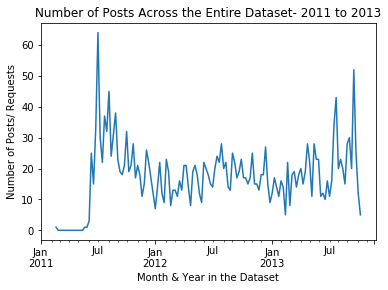

In [145]:
d = pd.DataFrame()
d['datetime'] = pd.to_datetime(train_df["unix_timestamp_of_request"], unit = 's')
d.index = d['datetime']
d['datetime'].resample('W').count().plot().set_title('Number of Posts Across the Entire Dataset- 2011 to 2013')
plt.xlabel('Month & Year in the Dataset')
plt.ylabel('Number of Posts/ Requests')

We can see from the above graph that there were a lot of posts around the 6 month mark of the reddit community opening until about July 2011. There also seems to be a spike towards the end of the dataset- July & August 2013. 

#### 2. Fulfillment of Requests over Months

This would show us how many Pizza givers there were over the entire duration of the dataset between 2011 and 2013. 

Text(0,0.5,'Percentage of Fulfilled Requests')

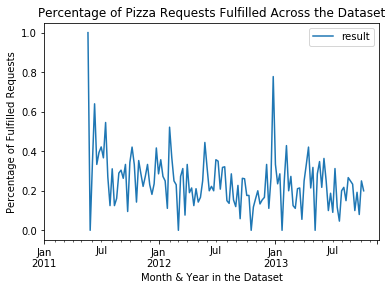

In [146]:
d = pd.DataFrame()
d['datetime'] = pd.to_datetime(train_df["unix_timestamp_of_request"], unit = 's')
train_labels = train_df["requester_received_pizza"]
d['result'] = train_labels
d.index = d['datetime']
d.resample('W').mean().plot().set_title("Percentage of Pizza Requests Fulfilled Across the Dataset")
plt.xlabel('Month & Year in the Dataset')
plt.ylabel('Percentage of Fulfilled Requests')

The above plot shows that request fulfillment was at its highest at the start of the group. However despite a few peaks during the Winter (Dec-Jan season) the overall fulfillment % has fallen over time. This shows that people are more willing to give during the Holiday season.

#### 3. Day of the Week 

Let's now look into whether the Day of the Week played a role in Pizza request fulfillments.

In [147]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
d['Day_of_Week'] = d['datetime'].dt.weekday_name
week_df = d.groupby('Day_of_Week').agg(['mean', 'count']).reindex(days)
week_df

result      
                 mean count
Day_of_Week                
Monday       0.259669   362
Tuesday      0.235127   353
Wednesday    0.217604   409
Thursday     0.302053   341
Friday       0.258786   313
Saturday     0.204473   313
Sunday       0.246246   333

The fulfillment rate varies between 21.7% (Wednesday) to 30.2% (Thursday). 
This seems like a reasonably distinguishing feature that should be considered for our model. 

#### 4. Time of the Day

Let's now look into whether the Time of the Day played a role in Pizza request fulfillments. 

Text(0,0.5,'Number of Requests')

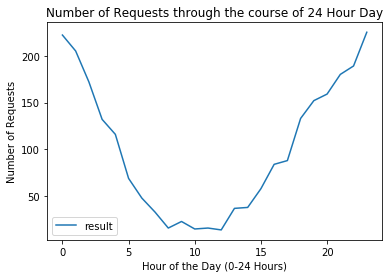

In [148]:
d['hour'] = d['datetime'].dt.hour
d[['hour', 'result']].groupby('hour').agg('count').plot().set_title("Number of Requests through the course of 24 Hour Day")
plt.xlabel('Hour of the Day (0-24 Hours)')
plt.ylabel('Number of Requests')

We can see from the above graph that the number of posts/ requests spikes up considerably during the night times- Between 8 PM and 3 AM with a peak around Midnight. 

Text(0,0.5,'Percentage of Fulfilled Requests')

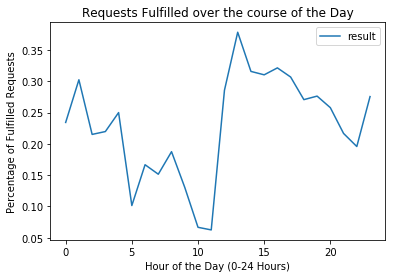

In [149]:
d[['hour', 'result']].groupby('hour').agg('mean').plot().set_title("Requests Fulfilled over the course of the Day")
plt.xlabel('Hour of the Day (0-24 Hours)')
plt.ylabel('Percentage of Fulfilled Requests')

We can see from the above graph that the number of fulfilled requests varies from 6% to 38% depending on the time of the day.

#### 5. Visualize requests and granted requests over time

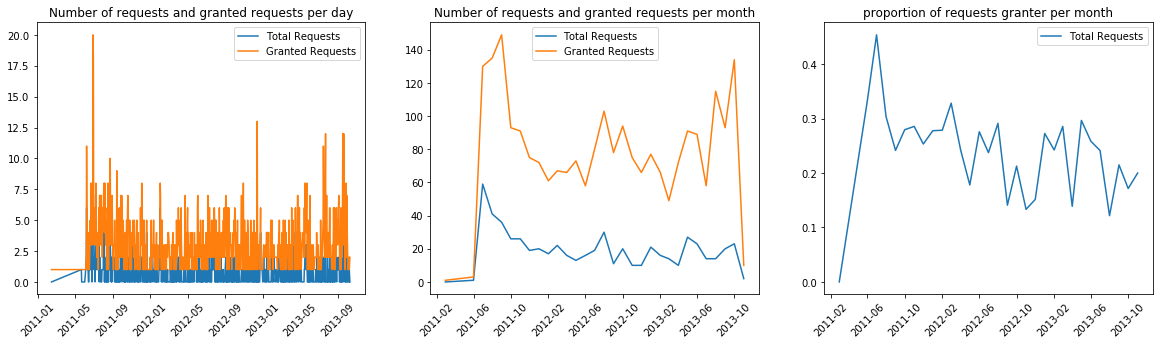

In [150]:
# Data setup
train_align_test = train_align_test.assign(
    unix_timestamp_of_request = pd.to_datetime(train_align_test.unix_timestamp_of_request, unit = "s"),
    unix_timestamp_of_request_utc = pd.to_datetime(train_align_test.unix_timestamp_of_request_utc, unit = "s"))

ts = pd.DataFrame({'granted requests':train_df.requester_received_pizza.tolist(),
                   'requests':[1] * train_df[['requester_received_pizza']].shape[0]},
                  index = train_align_test.unix_timestamp_of_request.dt.date.tolist())
ts = ts.groupby(ts.index).sum()

ts_month = pd.DataFrame({'granted requests':train_df.requester_received_pizza.tolist(),
                         'requests':[1] * train_df[['requester_received_pizza']].shape[0]},
                        index = (train_align_test.unix_timestamp_of_request.dt.date + pd.offsets.MonthBegin(0)).tolist())
ts_month = ts_month.groupby(ts_month.index).sum()

# Plots
# 1. By day
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.plot(ts)
plt.title("Number of requests and granted requests per day")
plt.legend(['Total Requests','Granted Requests'])
plt.xticks(rotation=45)

# 2. By Month
plt.subplot(1,3,2)
plt.plot(ts_month)
plt.title("Number of requests and granted requests per month")
plt.legend(['Total Requests','Granted Requests'])
plt.xticks(rotation=45)

# 3. By Month (proportion)
plt.subplot(1,3,3)
plt.plot(ts_month.assign(prop_granted = ts_month['granted requests'] / ts_month['requests'])['prop_granted'])
plt.title("proportion of requests granter per month")
plt.xticks(rotation=45)
plt.legend(['Total Requests','Granted Requests'])
plt.show()

<a id="profile"></a>  
### 3.4 Requester Profile Variables

Next, let's take a deeper dive into the featues related to the profile of the requester. As mentioned above, we identify some of the features as our primary profile features (i.e. features which an average reader/potential giver on RAOP may see/consider) and some as our secondary features (i.e. extended detail about requester activity on Reddit that a potential giver might not see, and therefore it wouldn't have as much influence on their likelihood of fulfilling the request or not).

Let's start by taking a look at the pairplot of a few of these variables

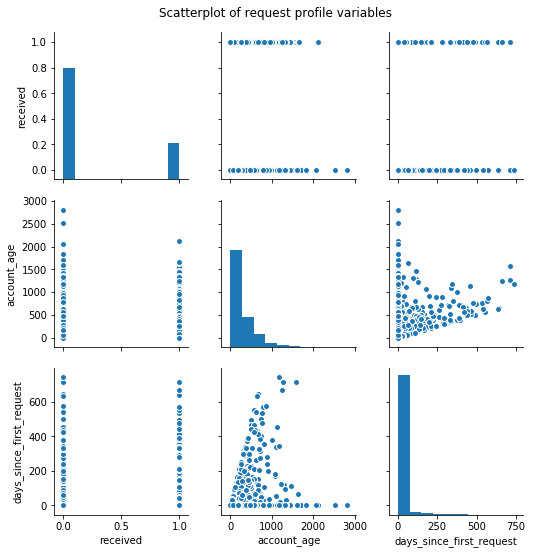

In [151]:
train_align_test['requester_received_pizza_int'] = train_align_test.requester_received_pizza.astype(int)

train_profile = pd.DataFrame({'received':train_align_test.requester_received_pizza_int.tolist(),
                              'account_age':train_align_test.requester_account_age_in_days_at_request.tolist(),
                              'days_since_first_request':train_align_test.requester_days_since_first_post_on_raop_at_request.tolist()})

sns.pairplot(train_profile).fig.suptitle('Scatterplot of request profile variables', y=1.02);

We note a few interesting trends in the above pairplot:
- There are many 0-day accounts and first time posters
    - For `requester_account_age_in_days_at_request` we might want to isolate 0-day accounts and then stratify by a few key buckets
    - For `requester_days_since_first_post_on_raop_at_request` there is even more of a dramatic shift from 0, therefore we should defintely create a categorical feature that distinguishes "first-time" vs "repeat" requesters
- The floor on mid-right scatterplot (days_since_first_request vs account_age) shows that some people post to RAOP on the first day of their account then continue on until posting again

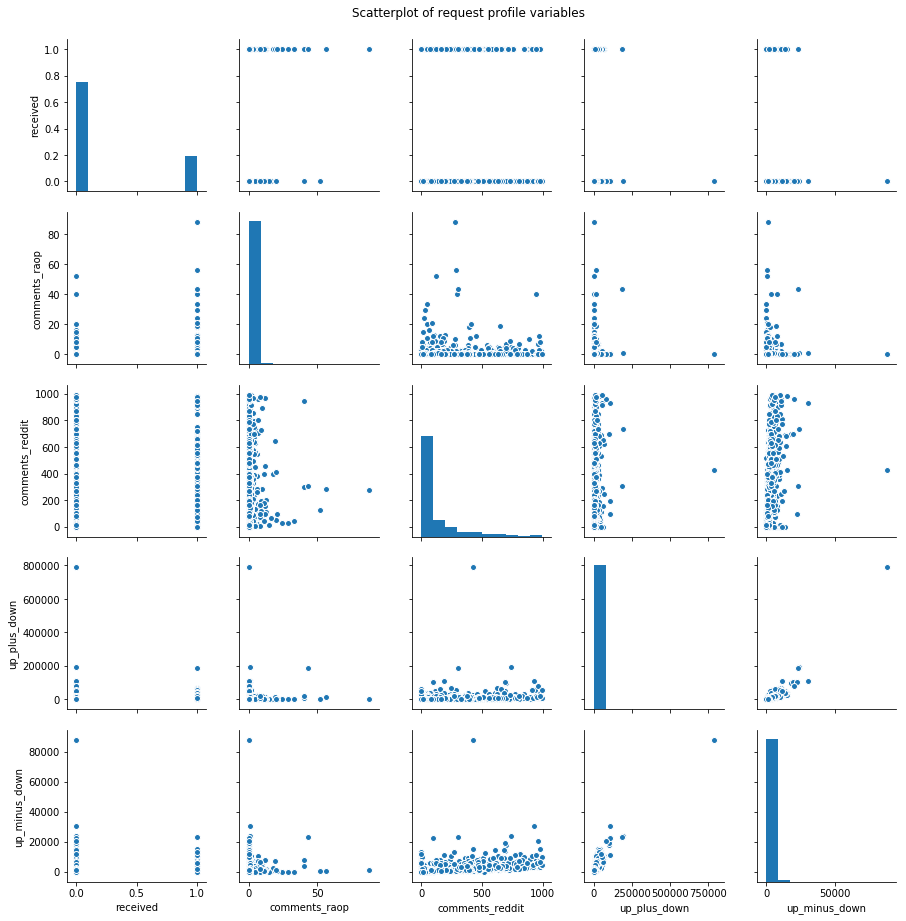

In [152]:
# Comments, Reddit and RAOP (not posts - it aligns too much with days since last post, very few observations)
# Up/Down Votes
train_part = pd.DataFrame({'received':train_align_test.requester_received_pizza_int.tolist(),
                           'comments_raop':train_align_test.requester_number_of_comments_in_raop_at_request.tolist(),
                           'comments_reddit':train_align_test.requester_number_of_comments_at_request.tolist(),
                           'up_plus_down':train_align_test.requester_upvotes_plus_downvotes_at_request.tolist(),
                           'up_minus_down':train_align_test.requester_upvotes_minus_downvotes_at_request.tolist()})

sns.pairplot(train_part).fig.suptitle('Scatterplot of request profile variables', y=1.02);

Based on the activity variable pairplot:
- We see lots of users not being particularly active 
    - Tons of 0 values on participation metrics
    - Big leading spike in comments relative to up/downvotes makes sense - must comment many times before receiving a lot of attention 
- Only noticeable correlation with received is RAOP participation
    - Comments in RAOP not particularly correlated with comments outside of RAOP (justification for focusing exclusively on RAOP participation metrics)

<a id="textual"></a>  
### 3.5 Textual Features

**CITATION** : Tim Althoff, Cristian Danescu-Niculescu-Mizil, Dan Jurafsky. How to Ask for a Favor: A Case Study on the Success of Altruistic Requests, Proceedings of ICWSM, 2014.

#### a) Non Negative Matrix Factorization (NMF)

To identify the different kinds of stories we draw on previous literature suggesting that narratives can be automatically extracted using topic modeling and related techniques. We therefore perform topic modeling through non negative matrix factorization (NMF) of a TF-IDF weighted bag-of-words representation of the requests in our dataset.

In [153]:
# Display topics with the top 10 words in each topic
# Source : https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730

def display_topics(model, topics, feature_names, n_words):
    # Print the 5 most common topics with their count
    top_5 = Counter(topics).most_common(5)
    print('Top five most common topics with counts: {}'.format(str(top_5)))

    # Print each topic and the top n words
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic {}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_words - 1:-1]]))

In [154]:
def tfidf_with_nmf():
    tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, 
                                       min_df = 2, 
                                       max_features = 1000, 
                                       stop_words = 'english')
    tfidf = tfidf_vectorizer.fit_transform(train_align_test['request_text_edit_aware'])
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    nmf = NMF(n_components = 10, 
              random_state = 1, 
              alpha = 0.1, 
              l1_ratio = 0.5, 
              init = 'nndsvd').fit(tfidf)

    topics_vector_nmf = np.argmax(nmf.transform(tfidf), axis=1)

    return (nmf, topics_vector_nmf, tfidf_feature_names)

nmf, topics_vector_nmf, tfidf_feature_names = tfidf_with_nmf()
display_topics(nmf, topics_vector_nmf, tfidf_feature_names, 15)

Top five most common topics with counts: [(0, 1150), (1, 224), (3, 153), (8, 148), (2, 142)]

Topic 0:
food ve help money job time work day got days going know today new make

Topic 1:
pizza like thanks buy tonight hut craving ll send papa thank good nice awesome random

Topic 2:
com http imgur jpg www reddit png picture lt proof pic youtube gt use user

Topic 3:
pay forward promise soon ll friday able paycheck thanks cash possible gladly better happy broke

Topic 4:
hungry broke help pretty dont send thanks eat feeling super roommates food right pics ll

Topic 5:
love pizza forever says title pie tonight reading favor night surprise subreddit feeling broke family

Topic 6:
just want story sob don moved pizza got tired started craving sad know new school

Topic 7:
really appreciate right don use craving haven pizza broke wednesday afford story lately today hot

Topic 8:
paid week friday favor help till return don appreciated rent ramen title buy says won

Topic 9:
student college broke

The Top 5 topics can be put under the following categories
- Topic 0: Job
- Topic 1: Pizza / Craving
- Topic 3: Reciprocity
- Topic 8: Money
- Topic 2: Proof / Validation

#### b) LDA (Latent Dirichlet Allocation)

LDA is based on probabilistic graphical modeling while NMF relies on linear algebra.

A tf-idf transformer is applied to the bag of words matrix that NMF must process with the TfidfVectorizer. LDA on the other hand, being a probabilistic graphical model (i.e. dealing with probabilities) only requires raw counts, so a CountVectorizer is used. Stop words are removed and the number of terms included in the bag of words matrix is restricted to the top 1000.

In [155]:
def cv_with_lda():
    # LDA can only use raw term counts for LDA because it is a probabilistic graphical model
    tf_vectorizer = CountVectorizer(max_df = 0.95, 
                                    min_df = 2, 
                                    max_features = 1000, 
                                    stop_words = 'english')
    tf = tf_vectorizer.fit_transform(train_align_test['request_text_edit_aware'].tolist())
    tf_feature_names = tf_vectorizer.get_feature_names()

    # Run LDA
    lda = LatentDirichletAllocation(n_components = 10, 
                                    max_iter = 5, 
                                    learning_method = 'online', 
                                    learning_offset = 50.,
                                    random_state = 0).fit(tf)

    topics_vector_lda = np.argmax(lda.transform(tf), axis=1)

    return (lda, topics_vector_lda, tf_feature_names)

lda, topics_vector_lda, tf_feature_names = cv_with_lda()
display_topics(lda, topics_vector_lda, tf_feature_names, 15)

Top five most common topics with counts: [(0, 1824), (9, 335), (3, 53), (5, 52), (2, 51)]

Topic 0:
pizza just really help food ve don thanks like money job time week pay love

Topic 1:
butter uh peanut huh sweet stranger idea complete domino phone pizza buying 30 bag rock

Topic 2:
title says pizza love edit location pretty eat forgot works cash mom help time amazing

Topic 3:
card reddit pizza im credit www account code com paypal debit cash http verification thanks

Topic 4:
com http imgur jpg www pizza picture pic dog vet proof png hungry video pics

Topic 5:
pizza draw ll hungry pretty watch dont song help write dominos choice try different youtube

Topic 6:
reasons number dorm remember appreciated picky greatly peace roommate head crying needed pizza best hurt

Topic 7:
amp paycheck ve pay rice rent pizza busy living forward just help fiance bills appreciated

Topic 8:
pizza papa hut johns john like dominos dominoes gift domino husband 11 deliver nearby gt

Topic 9:
money got pay

The Top 5 topics can be put under the following categories
- Topic 0: Money / Job
- Topic 9: Money / Job
- Topic 5: Pizza
- Topic 2: General
- Topic 3: Verification

#### c) Word Visualization  

Through this, we want to visualize the common bigrams and compare them for successful and unsuccessful requests. We choose bigrams as unigrams alone makes little sense and trigrams are too rare to be useful. From these visuals we can start to get an idea of potential differentiatiors in terms of post content that might make a difference to whether a user gets pizza or not. 

In [156]:
def word_join(string,joiner=' '):
    return joiner.join(string.split())

joined_words = np.vectorize(word_join)

def output_wordcloud(message_list, ngram_in, title_in):
    CV = CountVectorizer(stop_words = 'english', ngram_range = ngram_in)
    cv_fit = CV.fit_transform(message_list)

    vocab = joined_words(CV.get_feature_names())
    frequency = list(cv_fit.toarray().sum(axis=0))
    word_score = dict(zip(vocab, frequency))

    wc = WordCloud(background_color="white",
                   max_words = 200,
                   stopwords = set(STOPWORDS),
                   height = 500,
                   width = 800,
                   contour_color='steelblue').fit_words(word_score)
    
    plt.title(title_in)
    plt.axis('off')
    plt.imshow(wc, cmap=plt.cm.gray, interpolation = 'bilinear')

    sorted_word_score = sorted(list(zip(vocab, frequency)), key=lambda x: -x[1])
    got_pizza = pd.DataFrame(sorted_word_score[:20], columns = ['Word', 'Freq'])
    got_pizza.plot.bar(x = 'Word', y = 'Freq')

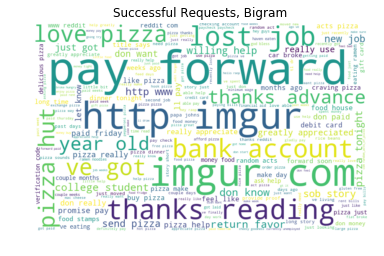

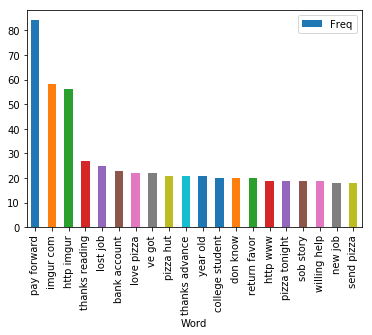

In [157]:
# Get text from variables where received pizza val was true
successful_edit_text = train_align_test[train_align_test['requester_received_pizza'] == True]['request_text_edit_aware']

# Bigram output
output_wordcloud(message_list = successful_edit_text, 
                 ngram_in = (2,2), 
                 title_in = "Successful Requests, Bigram")

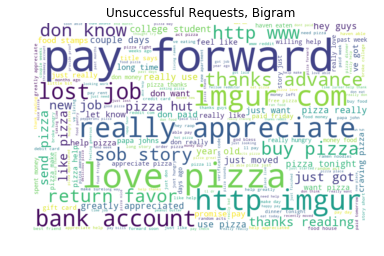

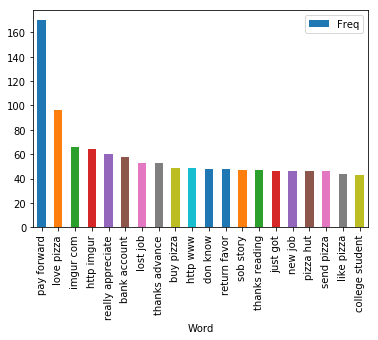

In [158]:
# Get text from variables where received pizza val was true
unsuccessful_edit_text = train_align_test[train_align_test['requester_received_pizza'] == False]['request_text_edit_aware']

# Bigram output
output_wordcloud(message_list = unsuccessful_edit_text, ngram_in = (2,2), title_in = "Unsuccessful Requests, Bigram")

There are some interesting differences such as amongst common phrases, what's interesting is how those who didn't get pizza mentioned "love pizza" and "pay forward" more often. Further, they also include images in the text

#### d) From the above, look at unigrams now

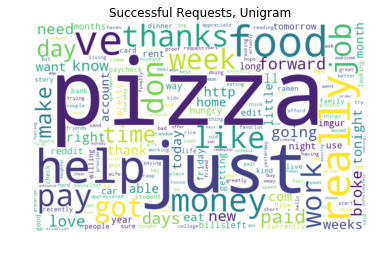

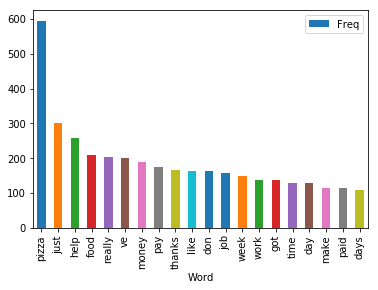

In [159]:
output_wordcloud(message_list = successful_edit_text, ngram_in = (1,1), title_in = "Successful Requests, Unigram")

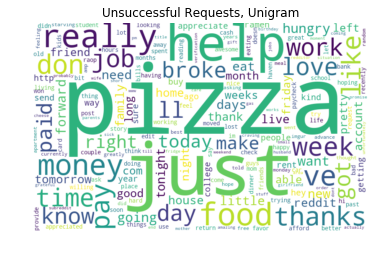

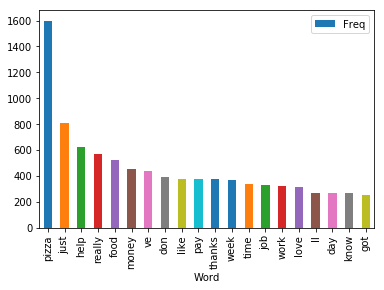

In [160]:
output_wordcloud(message_list = unsuccessful_edit_text, ngram_in = (1,1), title_in = "Unsuccessful Requests, Unigram")

<a id="baseline"></a>  
## 4. Baseline Model  

For our baseline models, we will run: 
- **ZeroR model** - predict the highest likelihood class for all observations (i.e. "guessing" blindly)  

- **Naive Bayes** - from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)    
Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. The independence assumption helps in making a non-biased prediction for our model. 

- **Logistic Regression** - from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)  
Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables. This is highly applicable in this scenario due to the binary nature of our outcome. 

- **XGBoost** - from [open source/xgboost developers](https://xgboost.readthedocs.io/en/latest/index.html)  
Random Forest or Random Decision Trees is a supervised learning algorithm. The "forest" it builds, is an ensemble of Decision Trees, trained with the “bagging” method. The general idea of the bagging method is that a combination of learning models increases the overall result. The ensemble is then boosted using a gradient boosting framework.

All models tuned using `GridSearchCV` from the [sklearn package](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to find optimal paramters.

Our baseline models will only rely on raw featues (including words) and we will test against the `dev` data we partitioned upfront.  
We will use a bag of words approach to vectorize the vocabulary of words used along with a few raw variables for each of our models. These variables are: 
- `requester_upvotes_plus_downvotes_at_request`
- `requester_number_of_comments_in_raop_at_request`
- `requester_days_since_first_post_on_raop_at_request`
- `requester_account_age_in_days_at_request`
- `requester_upvotes_minus_downvotes_at_request`.

In [161]:
# Use standard CountVectorizer to transform the training data and dev data 
vectorizer = CountVectorizer()
train_bag_of_words = vectorizer.fit_transform(train_df['request_text_edit_aware'])
dev_bag_of_words = vectorizer.transform(dev_df['request_text_edit_aware'])
test_bag_of_words = vectorizer.transform(test_df['request_text_edit_aware'])

# Limit data frames to key variables of interest
list_vars_raw_keep = ['requester_upvotes_plus_downvotes_at_request', 
                      'requester_number_of_comments_in_raop_at_request',
                      'requester_days_since_first_post_on_raop_at_request',
                      'requester_account_age_in_days_at_request',
                      'requester_upvotes_minus_downvotes_at_request']

train_df_base = train_df[list_vars_raw_keep]
train_text_df_base = pd.DataFrame(train_bag_of_words.toarray(), columns = vectorizer.vocabulary_)
train_df_base_complete = pd.concat([train_df_base.reset_index(), train_text_df_base], axis = 1)
train_df_base_complete = train_df_base_complete.drop(columns = ['index'])

dev_df_base = dev_df[list_vars_raw_keep]
dev_text_df_base = pd.DataFrame(dev_bag_of_words.toarray(), columns = vectorizer.vocabulary_)
dev_df_base_complete = pd.concat([dev_df_base.reset_index(), dev_text_df_base], axis = 1)
dev_df_base_complete = dev_df_base_complete.drop(columns = ['index'])

test_df_base = test_df[list_vars_raw_keep]
test_text_df_base = pd.DataFrame(test_bag_of_words.toarray(), columns = vectorizer.vocabulary_)
test_df_base_complete = pd.concat([test_df_base.reset_index(), test_text_df_base], axis = 1)
test_df_base_complete = test_df_base_complete.drop(columns = ['index'])

In [162]:
def roc_plot(dev_labels, pred_dev_prob):
    fpr, tpr, threshold = metrics.roc_curve(dev_labels, pred_dev_prob)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def confusion_plot(confusion_matrix, target_names):
    # Plot confusion matrix (via imshow)
    plt.imshow(confusion_matrix, interpolation = "nearest", cmap = plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    # Loop through each value of the matrix to add data labels
    width, height = confusion_matrix.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(confusion_matrix[x][y]), xy = (y, x), 
                        horizontalalignment = "center",
                        verticalalignment = "center")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
def standard_output(labels_in, pred_prob_in, pred_class_in):
    # AUC
    print("AUC score = {} \n".format(round(roc_auc_score(labels_in, pred_prob_in, average = 'micro'), 3)))
    # Classification Report
    print(classification_report(labels_in, pred_class_in))
    # Confusion Matrix
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    confusion_plot(confusion_matrix = confusion_matrix(y_true = labels_in, 
                                                       y_pred = pred_class_in), 
                   target_names = ["No Pizza", "Pizza"])
    # ROC
    plt.subplot(1,2,2)
    roc_plot(labels_in, pred_prob_in)
    
# Will stratify model data throughout for parallel processing to speed up training
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 7)

<a id="bzeroR"></a>  
### 4.1 - ZeroR Baseline  

The ZeroR rule is applied by predicting the highest class proportion of training data to all dev data. In this case that means all requests are predicted as 'No pizza received.'

In [163]:
# dev_labels vs. vector of 1/0 based on guessing all 1/0 (majority %)
zeror_prob = np.repeat(train_df['requester_received_pizza'].mean(), len(dev_labels))
zeror_class = np.repeat(round(train_df['requester_received_pizza'].mean(),0), len(dev_labels))

AUC score = 0.5 

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      1218
           1       0.00      0.00      0.00       398

   micro avg       0.75      0.75      0.75      1616
   macro avg       0.38      0.50      0.43      1616
weighted avg       0.57      0.75      0.65      1616



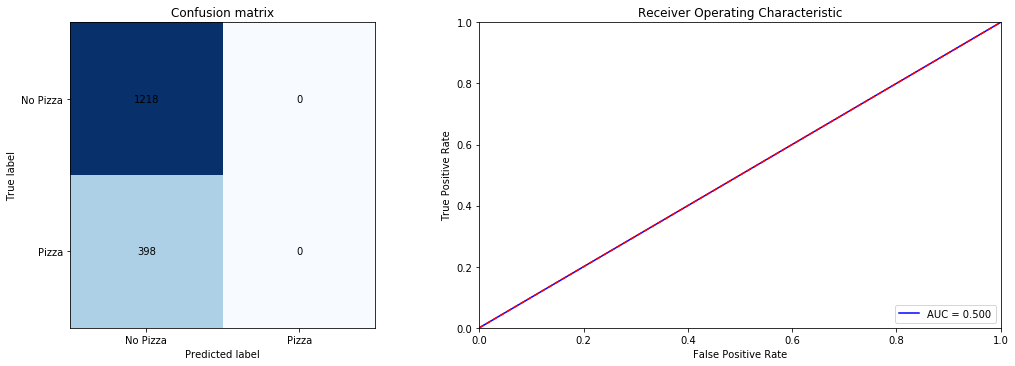

In [164]:
standard_output(labels_in = dev_labels, 
                pred_prob_in = zeror_prob, 
                pred_class_in = zeror_class)

**Result:** With an auc of 0.5, the ZeroR model is as accurate as randomly guessing (though is still accurate 75% of the time).

<a id="bnb"></a>  
### 4.2 Naive Bayes Baseline  

We next try a **Multinomial Naive Bayes** model where we use `GridSearchCV` to find the optimal value of `alpha`. Naive Bayes is the most straightforward modeling approach to take in terms of model assumptions (feature independence) and complexity. Furthermore, Naive Bayes works well with text as word counts are natural features for Naive Bayes since we calculate probabilities from observation counts.

Best Alpha parameter: 10.0
AUC score = 0.523 

              precision    recall  f1-score   support

           0       0.76      0.36      0.49      1218
           1       0.25      0.64      0.36       398

   micro avg       0.43      0.43      0.43      1616
   macro avg       0.50      0.50      0.42      1616
weighted avg       0.63      0.43      0.46      1616



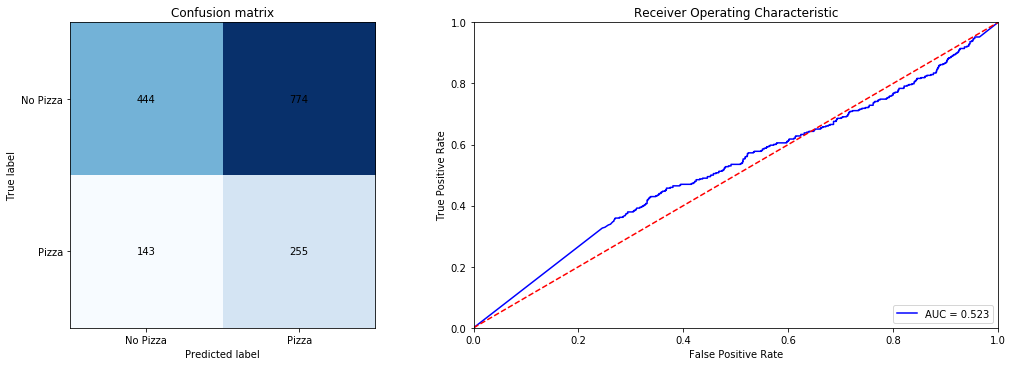

In [168]:
# Drop requester_upvotes_minus_downvotes_at_request (negative values)
train_df_base_complete_pos = train_df_base_complete.drop(columns = ['requester_upvotes_minus_downvotes_at_request'])
dev_df_base_complete_pos = dev_df_base_complete.drop(columns = ['requester_upvotes_minus_downvotes_at_request'])

# Create MultinomialNB
mnb = MultinomialNB()

# Use GridSearchCV to find the best value for alpha 
alpha_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
mnb_base_cv = GridSearchCV(mnb, 
                           alpha_params, 
                           cv = kfold,
                           return_train_score = True)
mnb_base_cv.fit(train_df_base_complete_pos, train_labels)
print('Best Alpha parameter: ' + str(mnb_base_cv.best_params_['alpha']))

# Predict dev data
dev_pred_mnb_base = mnb_base_cv.predict(dev_df_base_complete_pos)
dev_prob_mnb_base = mnb_base_cv.predict_proba(dev_df_base_complete_pos)[:,1]

# Standard output
standard_output(labels_in = dev_labels, 
                pred_prob_in = dev_prob_mnb_base, 
                pred_class_in = dev_pred_mnb_base)

**Result:** With an auc of 0.523, the Naive Bayes baseline model performs slightly better than ZeroR (though is much less accurate). This model is very overconfident in pizza requests filled.

<a id="blr"></a>  
### 4.3 Logistic Regression Baseline  

Now, we take a look at **Logistic Regression** with an `l2` penalty and a `liblinear` solver along with the same train and dev dataset as our other models. We use `GridSearchCV` to find the optimal value of `C`.

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   45.5s finished


Best C parameter: 0.1
AUC score = 0.591 

              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1218
           1       0.41      0.15      0.22       398

   micro avg       0.74      0.74      0.74      1616
   macro avg       0.59      0.54      0.53      1616
weighted avg       0.68      0.74      0.69      1616



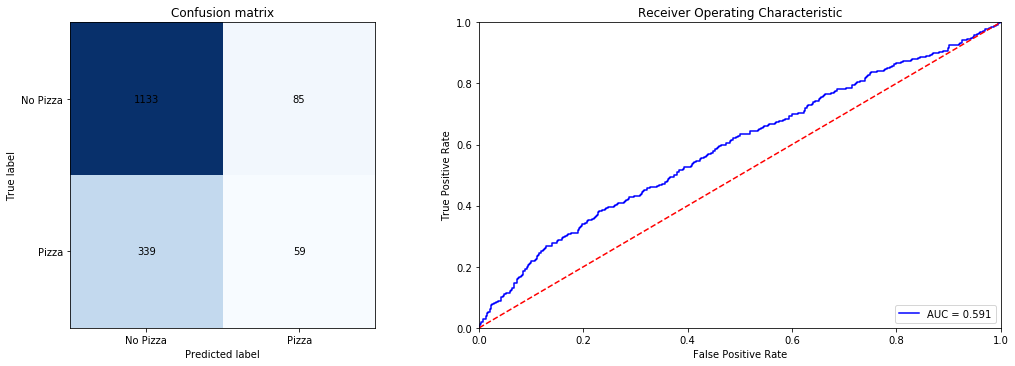

In [167]:
# Create Logistic Regression
logitreg = LogisticRegression(penalty = 'l2', solver = 'liblinear', max_iter = 1000, multi_class = 'auto')

# GridSearchCV over range of values of 'C' to find optimal value
c_params = {'C': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 2.0, 5.0, 10.0]}
logitreg_base_cv = GridSearchCV(logitreg, 
                                c_params,
                                scoring = "roc_auc",
                                return_train_score = True,
                                n_jobs = -1, 
                                cv = kfold, 
                                verbose = 1)
logitreg_base_cv.fit(train_df_base_complete, train_labels)
print('Best C parameter: ' + str(logitreg_base_cv.best_params_['C']))

# Predict dev data
dev_pred_logitreg_base = logitreg_base_cv.predict(dev_df_base_complete)
dev_prob_logitreg_base = logitreg_base_cv.predict_proba(dev_df_base_complete)[:,1]

# Standard output
standard_output(labels_in = dev_labels, 
                pred_prob_in = dev_prob_logitreg_base, 
                pred_class_in = dev_pred_logitreg_base)

**Result:** With an auc of .595, the logistic baseline model performs better than either of the previous models and achieves nearly the same accuracy of ZeroR. It is much more conservative than Naive bayes, and accurately predicts many No Pizza requests, but is also missing many fulfilled requests.

<a id="bxg"></a>  
### 4.4 XGBoost Baseline  

Finally, our last baseline model uses the **xgboost** model where we also use `GridSearchCV` to find the optimal values for `n_estimators` and `max_depth`. Note that the xgboost algorithm will be run on the raw non-word features only, as the size and complexity of 9,000+ word features creates a prohibitively slow model, even when parrallelized as set up below.

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.3s finished


Best parameters:
{'max_depth': 2, 'n_estimators': 50}
AUC score = 0.584 

              precision    recall  f1-score   support

           0       0.80      0.52      0.63      1218
           1       0.29      0.60      0.39       398

   micro avg       0.54      0.54      0.54      1616
   macro avg       0.54      0.56      0.51      1616
weighted avg       0.67      0.54      0.57      1616



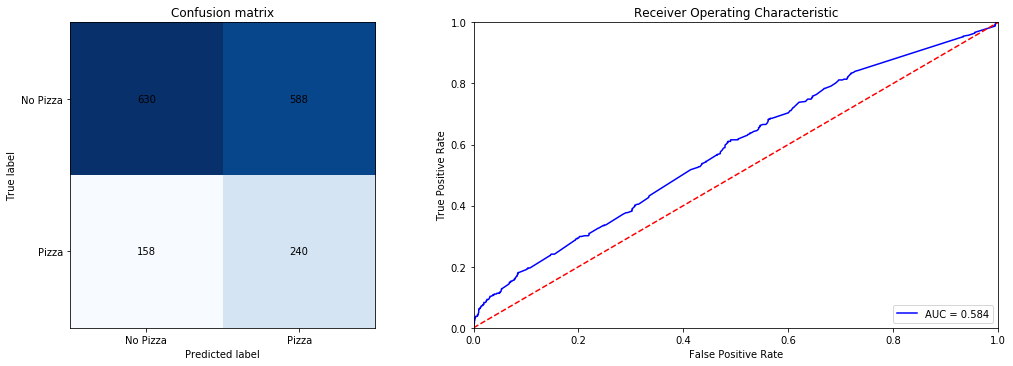

In [169]:
xgb_train = train_df_base
xgb_dev = dev_df_base

# Caluclate training weights
local_pos = (len(train_labels) - np.sum(train_labels)) / np.sum(train_labels)

# Create XGBoost model
    # CITATIONS: 
        # Algorithm: https://xgboost.readthedocs.io/en/latest/python/python_api.html#
        # Tuning: https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/
            
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', 
                              eval_metric = 'auc',
                              scale_pos_weight = local_pos)

# GridSearchCV over range of parameters to find optimal value
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
xgb_param_grid = dict(max_depth = max_depth, n_estimators = n_estimators)

xgb_base_cv = GridSearchCV(xgb_model, 
                           xgb_param_grid, 
                           scoring = "roc_auc",
                           return_train_score = True,
                           n_jobs = -1, 
                           cv = kfold, 
                           verbose = 1)
xgb_base_cv.fit(xgb_train, train_labels)
print('Best parameters:')
print(xgb_base_cv.best_params_)

# Predict dev data
dev_pred_xgb_base = xgb_base_cv.predict(xgb_dev)
dev_prob_xgb_base = xgb_base_cv.predict_proba(xgb_dev)[:, 1]

standard_output(labels_in = dev_labels, 
                pred_prob_in = dev_prob_xgb_base, 
                pred_class_in = dev_pred_xgb_base)

**Results:** With an auc of .584, the xgboos baseline model does better than randomly guessing (auc of .5). However, the logistic regression baseline model gives us the best AUC score. XGBoost is more accurately predicting requests that received pizza but is also creating too many false positives.

<a id="featengg"></a>  
## 5. Feature Engineering  

Now, we move onto feature engineering where we develop new features from existing raw variables that can help improve the accuracy of our models.

In [170]:
# Final dataframes - to be appended with new features in the following sub-sections
train_feat_mat = pd.DataFrame()
dev_feat_mat = pd.DataFrame()
test_feat_mat = pd.DataFrame()

# Resest index on train_df_base and dev_df_base
train_df_base_2 = train_df_base.reset_index()
train_df_base_2 = train_df_base_2.drop(columns = ['index', 'requester_upvotes_minus_downvotes_at_request'])

dev_df_base_2 = dev_df_base.reset_index()
dev_df_base_2 = dev_df_base_2.drop(columns = ['index', 'requester_upvotes_minus_downvotes_at_request'])

test_df_base_2 = test_df_base.reset_index()
test_df_base_2 = test_df_base_2.drop(columns = ['index', 'requester_upvotes_minus_downvotes_at_request'])

# Use as basis for final feature matrix
train_feat_mat = train_df_base_2.copy()
dev_feat_mat = dev_df_base_2.copy()
test_feat_mat = test_df_base_2.copy()

# Resest index on train_df and dev_df
train_df = train_df.reset_index()
train_df = train_df.drop(columns = ['index'])

dev_df = dev_df.reset_index()
dev_df = dev_df.drop(columns = ['index'])

test_df = test_df.reset_index()
test_df = test_df.drop(columns = ['index'])

<a id="fe_time"></a>  
### 5.1 Time

**A. 'During Initial Period':**

The first two graphs in the Time Section indicate that during the initial period of the group, there was a burst of requests and an unsustained high rate of fulfillment. This doesn't align with the general trend. It might be interesting to analyze the differences between the Initial_period (Until July 2011) vs Not_Initial Period. 

In [171]:
def add_time_features(input_df, output_df):
    cutoff_date = datetime.date(2011,7,31) # Cutting off on July 31
    cutoff_time = time.mktime(cutoff_date.timetuple())
    output_df['during_initial_period'] = np.where(input_df['unix_timestamp_of_request_utc'] < cutoff_time, 1, 0)
    return output_df

We fit an exponential decay on the month of the request starting August 2011.

In [172]:
## Reference on subset: https://www.earthdatascience.org/courses/earth-analytics-python/use-time-series-data-in-python/subset-time-series-data-python/
ts_month2 = ts_month.assign(prop_granted = ts_month['granted requests'] / ts_month['requests'])
ts_month2['log_prop_granted'] = np.log(ts_month2['prop_granted'])
ts_month2['dateMo'] = pd.to_datetime(ts_month2.index)
ts_month2['dateMo_threshold'] = pd.to_datetime('2011-08-01')
ts_month2['diff_August2011'] = (ts_month2['dateMo'].dt.year - ts_month2['dateMo_threshold'].dt.year) * 12 + ts_month2['dateMo'].dt.month - ts_month2['dateMo_threshold'].dt.month
ts_month_subset = ts_month2['2011-08-01':]

0.45384615384615384


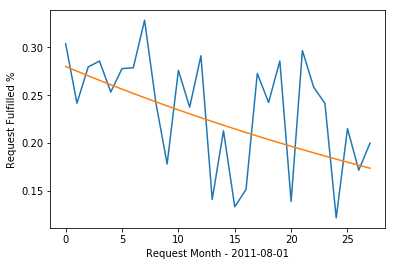

In [173]:
expDecay_t = ts_month_subset['diff_August2011'].values.astype(float)
expDecay_y = ts_month_subset['prop_granted'].values.astype(float)
expDecay_log_y = ts_month_subset['log_prop_granted'].values.astype(float)
expDecay_w = ts_month_subset['requests'].values.astype(float)
expDecay_K, expDecay_A_log = np.polyfit(expDecay_t,expDecay_log_y,w=expDecay_w, deg=1)
expDecay_A = np.exp(expDecay_A_log)
expDecay_fit_y = expDecay_A * np.exp (expDecay_K * expDecay_t)
plt.plot(expDecay_t, expDecay_y)
plt.plot(expDecay_t, expDecay_fit_y)
plt.xlabel('Request Month - 2011-08-01')
plt.ylabel('Request Fulfilled %')

expDecay_July2011 = ts_month2['prop_granted'][ts_month2['dateMo']=='2011-07-01'][0]
print(expDecay_July2011)

In [174]:
def add_time_features(input_df, output_df):
    cutoff_date = datetime.date(2011,7,31) # Cutting off on July 31
    cutoff_time = time.mktime(cutoff_date.timetuple())
    output_df['during_initial_period'] = np.where(input_df['unix_timestamp_of_request_utc'] < cutoff_time, 1, 0)
    
    request_month = pd.DataFrame({'month':(pd.to_datetime(input_df['unix_timestamp_of_request_utc'], unit = "s").dt.date + pd.offsets.MonthBegin(0)).tolist()})
    request_month['threshold'] = pd.to_datetime('2011-08-01')
    request_month['month'] = pd.to_datetime(request_month['month'])
    request_month['diff_August2011'] = (request_month['month'].dt.year - request_month['threshold'].dt.year) * 12 + request_month['month'].dt.month - request_month['threshold'].dt.month
    request_month['expDecay'] = expDecay_A * np.exp (expDecay_K * request_month['diff_August2011'].astype(float))
    output_df['monthExpDecay'] = np.where(request_month['month'] < '2011-08-01', expDecay_July2011, request_month['expDecay'])
    print(request_month)
    return output_df


train_feat_mat = add_time_features(input_df = train_df,
                                   output_df = train_feat_mat)
dev_feat_mat = add_time_features(input_df = dev_df,
                                 output_df = dev_feat_mat)
test_feat_mat = add_time_features(input_df = test_df,
                                  output_df = test_feat_mat)

          month  threshold  diff_August2011  expDecay
0    2011-09-01 2011-08-01                1  0.275132
1    2012-04-01 2011-08-01                8  0.243094
2    2012-12-01 2011-08-01               16  0.211021
3    2013-05-01 2011-08-01               21  0.193161
4    2011-08-01 2011-08-01                0  0.280042
5    2011-12-01 2011-08-01                4  0.260915
6    2013-05-01 2011-08-01               21  0.193161
7    2011-12-01 2011-08-01                4  0.260915
8    2012-11-01 2011-08-01               15  0.214786
9    2013-10-01 2011-08-01               26  0.176813
10   2013-07-01 2011-08-01               23  0.186448
11   2013-10-01 2011-08-01               26  0.176813
12   2011-12-01 2011-08-01                4  0.260915
13   2012-11-01 2011-08-01               15  0.214786
14   2012-01-01 2011-08-01                5  0.256341
15   2011-11-01 2011-08-01                3  0.265570
16   2013-03-01 2011-08-01               19  0.200116
17   2013-02-01 2011-08-01  

**B. 'Time of Day' & 'Hour_of_Day':**

The third graph in the Time Section indicate that fulfillment rates oscillate between 21% & 30% based on day of the week. This isn't significant enough to be considered a distinguishing feature.

Time of the day provides an interesting variation between 6% and 38%. However posts from multiple days/ times are available for givers to select from an fulfill.  Hence this can't be used as a feature since it doesn't help us in identifying a characteristic of the Request Post. 

<a id="fe_reqprofile"></a>  
### 5.2 Requester Profile Variables

In [175]:
def add_profile_features(input_df, output_df):
    # Age of account
    median_account_age_nonzero = input_df[input_df['requester_account_age_in_days_at_request']!=0]['requester_account_age_in_days_at_request'].median()
    account_age_conditions = [
        (input_df.loc[:,'requester_account_age_in_days_at_request']==0),
        (input_df.loc[:,'requester_account_age_in_days_at_request']<=median_account_age_nonzero),
        (input_df.loc[:,'requester_account_age_in_days_at_request']>median_account_age_nonzero)]
    account_age_choices = ['throwaway', 'new', 'old']
    input_df['account_age_cat'] = np.select(account_age_conditions, account_age_choices, default='na')
    output_df['new'] = np.where(input_df['account_age_cat']=='new', 1, 0)
    output_df['throwaway'] = np.where(input_df['account_age_cat']=='throwaway', 1, 0)
    
    # Number and frequency of requests - if the requester has made requests before
    input_df['first_repeat_requester'] = np.where(input_df['requester_days_since_first_post_on_raop_at_request']==0, 'first', 'repeat')
    output_df['first_requester'] = np.where(input_df['first_repeat_requester']=='first', 1, 0)

    # Commenter
    input_df['comments_raop_cat'] = np.where(input_df['requester_number_of_comments_in_raop_at_request']==0, 'never', 'has')
    output_df['never_comments'] = np.where(input_df['comments_raop_cat']=='never', 1, 0)
    
    # Up Votes + Down Votes
    input_df['up_plus_down_cat'] = np.where(input_df['requester_upvotes_plus_downvotes_at_request']==0, 'ignored', 'popular')
    output_df['popular'] = np.where(input_df['up_plus_down_cat']=='popular', 1, 0)
    
    return input_df, output_df

In [176]:
train_df_base, train_feat_mat = add_profile_features(input_df = train_df,
                                                     output_df = train_feat_mat)
dev_df_base, dev_feat_mat = add_profile_features(input_df = dev_df,
                                                 output_df = dev_feat_mat)
test_df_base, test_feat_mat = add_profile_features(input_df = test_df,
                                                   output_df = test_feat_mat)

#### Age of Account

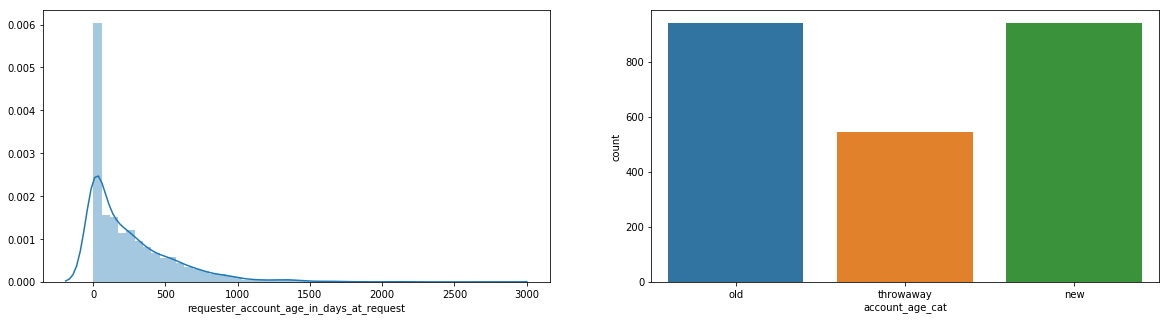

In [177]:
plt.figure(figsize=(20, 5))
# Age of account - whether it appears to be a new/throwaway account or a longtime veteran
plt.subplot(1,2,1)
sns.distplot(train_df.loc[:,'requester_account_age_in_days_at_request']);
# Create new variable for: first (days = 0), new (days <= median for nonzero), old (days > median for nonzero)
plt.subplot(1,2,2)
sns.countplot(x = 'account_age_cat', data = train_df_base)

#### First/Repeat Request

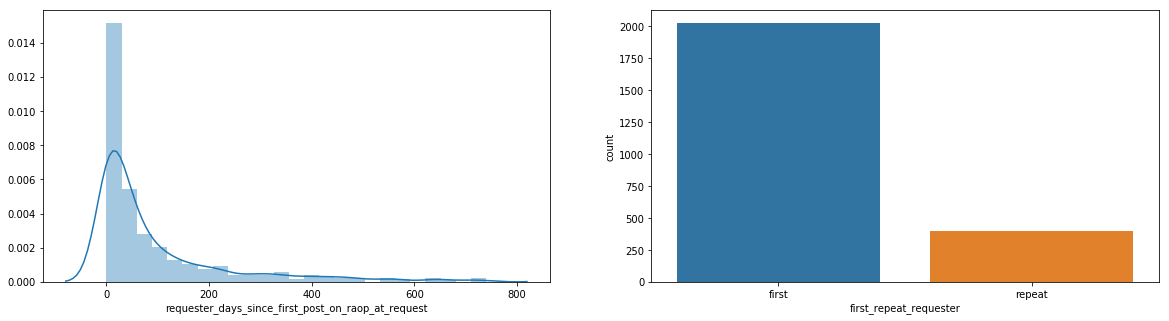

In [178]:
plt.figure(figsize=(20, 5))
# Days since request
plt.subplot(1,2,1)
# NOTE: 0 observations removed
sns.distplot(train_df.loc[train_df['requester_days_since_first_post_on_raop_at_request']!=0, 'requester_days_since_first_post_on_raop_at_request']);
# Create new variable for: first (days = 0), repeat (days > 0)
plt.subplot(1,2,2)
sns.countplot(x='first_repeat_requester', data = train_df_base)

#### Commenter

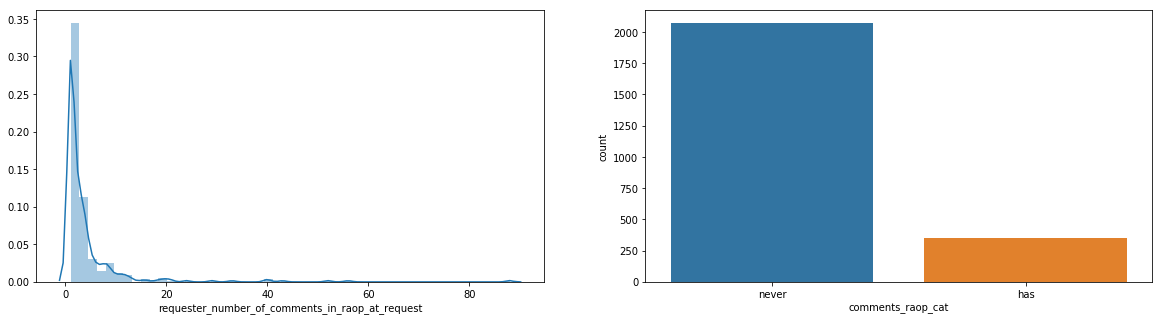

In [179]:
plt.figure(figsize=(20, 5))
# Number of RAOP comments
plt.subplot(1,2,1)
# NOTE: 0 observations removed
sns.distplot(train_df.loc[train_df['requester_number_of_comments_in_raop_at_request']!=0, 'requester_number_of_comments_in_raop_at_request']);
# Create new variable for: never (comments = 0), has (comments > 0)
plt.subplot(1,2,2)
sns.countplot(x = 'comments_raop_cat', data = train_df_base)

#### Up/Down Votes

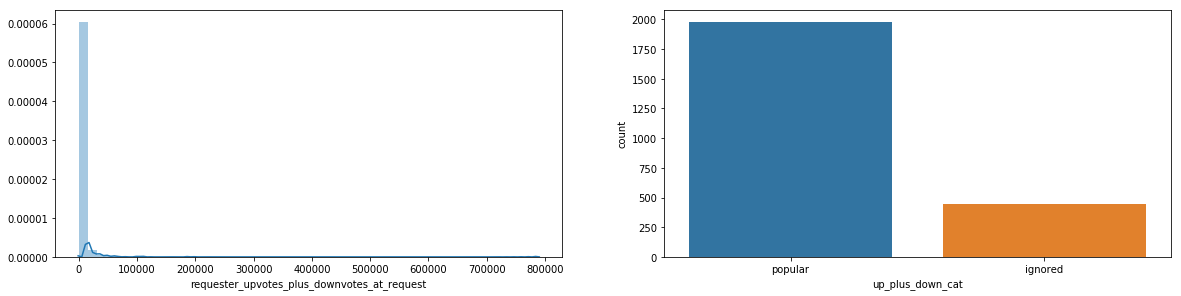

In [180]:
plt.figure(figsize=(20, 10))
# Up Plus Down
plt.subplot(2,2,1)
sns.distplot(train_df.loc[:,'requester_upvotes_plus_downvotes_at_request']);
# Up Plus Down Cat
plt.subplot(2,2,2)
sns.countplot(x = 'up_plus_down_cat', data = train_df_base)

<a id="fe_textual"></a>  
### 5.3 Textual Variables  
#### Methods

- Bag-of-words = base methodology  
The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.

- Topic modelling
Topic modeling is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents. Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic.

- Pre-Processing = potential (see dimensionality reduction)  

- Sentiment analysis

- Check whether the post matches with the Sub-Reddits the original poster subscribed

- Number of capitalized words

- Word Count

- Pruned vocabulary

From the Stanford paper, we read the part regarding narratives found in the posts and thus, we create features that identify words for each narrative in a given observation and calculate the feature for each narrative as a total count of the words in a given narrative in the text and divide by total text length.

In [181]:
# TOPIC WORD LISTS

topic_money = ["money", "now", "broke", "week", "until", "time",
          "last", "day", "when", "today", "tonight", "paid", "next",
          "first", "night", "after", "tomorrow", "month", "while",
          "account", "before", "long", "friday", "rent", "buy",
          "bank", "still", "bills", "ago", "cash", "due",
          "soon", "past", "never", "paycheck", "check", "spent",
          "years", "poor", "till", "yesterday", "morning", "dollars",
          "financial", "hour", "bill", "evening", "credit",
          "budget", "loan", "bucks", "deposit", "dollar", "current",
          "payed"]

topic_job = ["work", "job", "paycheck", "unemployment", "interview",
          "fired", "employment", "hired", "hire"]

topic_student = ["college", "student", "school", "roommate",
          "studying", "university", "finals", "semester",
          "class", "study", "project", "dorm", "tuition"]

topic_family = ["family", "mom", "wife", "parents", "mother", "husband",
           "dad", "son", "daughter", "father", "parent",
           "mum"]

topic_craving = ["friend", "girlfriend", "craving", "birthday",
          "boyfriend", "celebrate", "party", "game", "games",
          "movie", "date", "drunk", "beer", "celebrating", "invited",
          "drinks", "crave", "wasted", "invite"]

narratives = [topic_money, topic_job, topic_student, topic_family, topic_craving]

# FUNCTIONS

def pre_process(s):
    s = re.sub("[^\w']|_", " ", s) 
    s = s.translate(str.maketrans(' ',' ',string.punctuation))
    s = re.sub(' +',' ', s)
    s = s.lower()    
    return s

def find_narrative(narr,s):
    count = 0
    for word in narr:
        count += s.split().count(word)
    return count/len(s.split())

##### Count the number of words capitalized
Capitalization typically conveys stronger emotion and creates emphasis on certain parts of the sentence. We are interested in learning whether capitalization in the request text has any effect in one's chance of receiving the pizza. In counting the number of words capitalized, we exclude state abbreviations and a few other common abbreviations as they do not have the effect of stronger emotion or emphasis that we try to investigate.

In [182]:
request_text_edit_aware_train_np = train_df['request_text_edit_aware'].values
stateAbbrList = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]
otherExlcusionList = ['US', 'PS', 'EDIT', 'PM']
capCountList = []
capCategoryList = []

for i in range(len(request_text_edit_aware_train_np)):
    msg = request_text_edit_aware_train_np[i]
    ## Replace special characters with space
    msg = re.sub('[^1-9a-zA-Z\s]+', '', msg)
    capCount = 0
    for word in msg.split():
        ## Remove if a word has only 1 character (i.e., 'I')
        if len(word) > 1:
            if word.isupper() and word not in stateAbbrList and word not in otherExlcusionList:
                capCount += 1
        
    capCountList.append(capCount)

Below shows the average percentage of pizza requests fulfilled by the number of capitalized words in the request text:
            0     0
0    0.231884  1932
1    0.287324   355
2    0.298701    77
3    0.363636    22
4    0.583333    12
5    0.000000     5
6    0.333333     6
7    1.000000     4
8    0.000000     1
11   0.000000     2
12   1.000000     1
17   0.000000     1
23   0.500000     2
28   0.000000     1
35   0.000000     1
37   0.000000     1
118  0.000000     1


Text(0.5,0,'# of Capitalized Words')

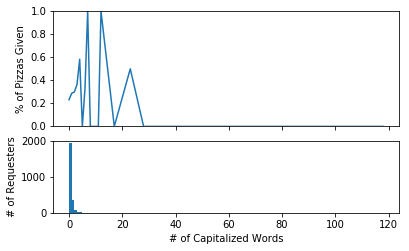

In [183]:
Y_train_np = train_df.as_matrix(columns = ['requester_received_pizza']).flatten()

## Average target in training by the number of capitalized words
Y_byCapCount = pd.DataFrame(Y_train_np).groupby(capCountList).mean()

## Total number of observations by the number of capitalized words
n_byCapCount = pd.DataFrame(Y_train_np).groupby(capCountList).count()
print('Below shows the average percentage of pizza requests fulfilled by the number of capitalized words in the request text:')
print(pd.concat([Y_byCapCount, n_byCapCount], axis = 1))

fig = plt.figure()
## Specify the dimensions [left, bottom, width, height]
ax1 = fig.add_axes([0.1, 0.4, 0.8, 0.4],
                   xticklabels=[], ylim=(0, 1))
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.25],
                   ylim=(0, 2000))

ax1.plot(np.unique(capCountList), Y_byCapCount)
ax1.set_ylabel('% of Pizzas Given')
ax2.hist(capCountList, 120)
ax2.set_ylabel('# of Requesters')
ax2.set_xlabel('# of Capitalized Words')

The top line chart shows the the average percentage of pizza requests fulfilled by the number of capitalized words in the request text. The averages change radically as the number of capitalized words increase. This is not surprising since the majority of requests doesn't have any word capitalized. So we decided to bin this feature into two categories: no capitalized word (0) and at least one capitalized word (1).  

**NOTE:** printed count table - shows a really small sample size on some of the higher obs, which could explain some of the variance we're seeing. Difference between 0 and >0 still interesting (below)

In [184]:
## Bin into 2 categories: Capitalization (Yes, No)
capCategoryList = np.where(np.asarray(capCountList)>=1, 1, 0)

## Avaerge target in training by the number of capCategory
Y_byCapCategory = pd.DataFrame(Y_train_np).groupby(capCategoryList).mean()

## Total number of observations by the number of capCategory
n_byCapCategory = pd.DataFrame(Y_train_np).groupby(capCategoryList).count()

print('Among the requests without any capitalized word, ' + '{:.1%}'.format(Y_byCapCategory[0][0]) + ' of them were fulfilled.')
print('Among the requests with at least one capitalized word, ' + '{:.1%}'.format(Y_byCapCategory[0][1]) + ' of them were fulfilled.')
print('There are %i requests without any capitalized word.' %n_byCapCategory[0][0])
print('There are %i requests with at least one capitalized word.' %n_byCapCategory[0][1])

Among the requests without any capitalized word, 23.2% of them were fulfilled.
Among the requests with at least one capitalized word, 30.1% of them were fulfilled.
There are 1932 requests without any capitalized word.
There are 492 requests with at least one capitalized word.


##### Sentiment Analysis

We use VADER sentiment analysis tools to perform sentiment analysis on each request text. VADER sentiment analysis calculates neutral, positive, negative, and compound score for each text. Compound score accounts for emphasis from punctuation in addition to sentiment captured by neural, positive, and negative words. 

**CITATION**: Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [185]:
## Reference: https://www.nltk.org/api/nltk.sentiment.html (CITATION NEEDED)
## Reference: http://www.nltk.org/howto/sentiment.html
sid = SentimentIntensityAnalyzer()
neuList = []
posList = []
negList = []
compoundSenList = []

for i in range(len(request_text_edit_aware_train_np)):
    msg = request_text_edit_aware_train_np[i] 
    ss = sid.polarity_scores(msg)
    neuList.append(ss['neu'])
    posList.append(ss['pos'])
    negList.append(ss['neg'])
    compoundSenList.append(ss['compound'])

Text(0.5,1,'Histogram of Compound Score')

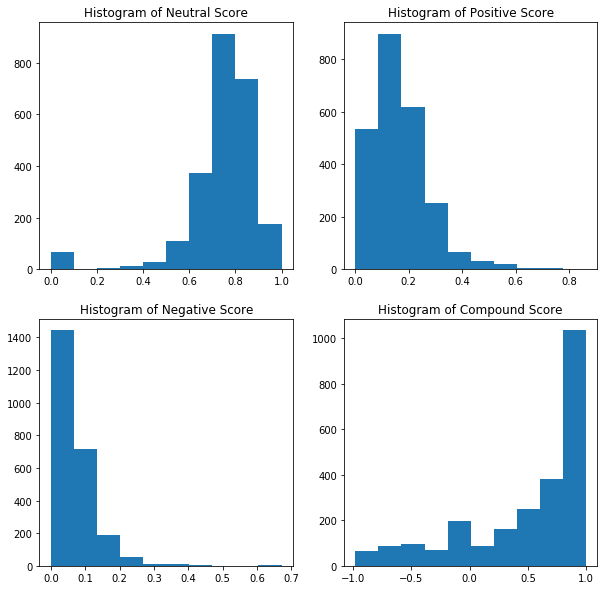

In [186]:
np.histogram(np.asarray(neuList), bins=[0, 0.25, 0.5, 0.75, 1])
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0,0].hist(np.asarray(neuList))
ax[0,0].set_title('Histogram of Neutral Score')
ax[0,1].hist(np.asarray(posList))
ax[0,1].set_title('Histogram of Positive Score')
ax[1,0].hist(np.asarray(negList))
ax[1,0].set_title('Histogram of Negative Score')
ax[1,1].hist(np.asarray(compoundSenList))
ax[1,1].set_title('Histogram of Compound Score')

We perform a logistic regression model to see which of the scores are statistically significant.

In [187]:
class LogisticReg:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 
    
    self.z_scores
    self.p_values
    self.sigma_estimates
    
    as well as the negative hessian of the log Likelihood (Fisher information)
    
    self.F_ij
    """
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.z_scores = z_scores
        self.p_values = p_values
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij

In [188]:
sentimentX = np.c_[np.asarray(neuList), np.asarray(posList), np.asarray(negList), np.asarray(compoundSenList)]
lgModel = LogisticReg()
lgModel.fit(sentimentX, Y_train_np)
print(lgModel.coef_)
print(lgModel.p_values)

## Note only neutral score and compound score are significant.

[[ 0.26727055 -0.65703415 -0.29422087  0.29115887]]
[0.03999100751959138, 0.2085141481356042, 0.7331524333979133, 0.033578742815243284]


Only neutral score and compound score are statistically significant with p-values of 0.047 and 0.027.

##### Word Count

In [189]:
## Count the number of words in a request text
wordCountList = []

for i in range(len(request_text_edit_aware_train_np)):
    msg = request_text_edit_aware_train_np[i] 
    wordCountList.append(len(re.findall(r'\w+', msg)))

wordCountList_np = np.asarray(wordCountList)

## There are a few cases where word counts are less than 10, investigate more
print(np.where(wordCountList_np < 10))
print(request_text_edit_aware_train_np[18])

(array([  12,   18,   21,   28,   30,   66,   91,   93,   97,  101,  104,
        234,  262,  280,  299,  307,  313,  320,  321,  334,  340,  347,
        352,  358,  393,  462,  486,  503,  523,  531,  552,  553,  564,
        585,  594,  599,  601,  604,  611,  613,  630,  643,  675,  715,
        717,  720,  740,  759,  764,  766,  780,  787,  802,  836,  843,
        846,  847,  891,  911,  941,  966,  976,  982, 1047, 1074, 1109,
       1136, 1171, 1178, 1214, 1230, 1233, 1273, 1311, 1316, 1333, 1371,
       1373, 1380, 1389, 1390, 1392, 1394, 1412, 1457, 1479, 1486, 1492,
       1500, 1519, 1520, 1535, 1550, 1569, 1597, 1606, 1609, 1614, 1618,
       1620, 1622, 1640, 1654, 1671, 1690, 1705, 1707, 1716, 1757, 1770,
       1776, 1783, 1817, 1854, 1862, 1870, 1921, 1947, 1965, 1971, 1973,
       2018, 2044, 2051, 2060, 2074, 2104, 2163, 2172, 2191, 2221, 2237,
       2246, 2262, 2274, 2277, 2287, 2306, 2323, 2334, 2371, 2383, 2386,
       2390, 2409, 2416]),)
**edit:** nevermind.


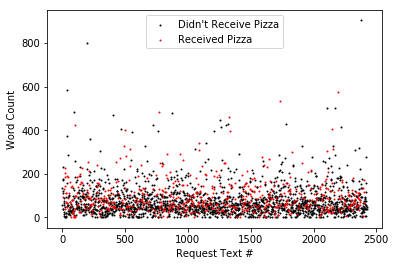

In [190]:
## Scatter plot word count for each request
plt.scatter(np.asarray(range(len(wordCountList)))[Y_train_np==False], wordCountList_np[Y_train_np==False], c='black', s=1, label="Didn't Receive Pizza")
plt.scatter(np.asarray(range(len(wordCountList)))[Y_train_np==True], wordCountList_np[Y_train_np==True], c='red', s=1, label="Received Pizza")
plt.xlabel('Request Text #')
plt.ylabel('Word Count')
plt.legend()

From the scatterplot above, we cannot observe an obvious pattern whether longer request texts contribute to a higher or lower chance of getting a pizza. So we try to visualize it after sorting the word count from low to high.

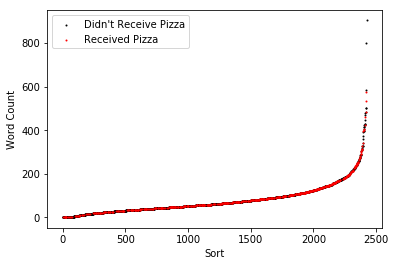

In [191]:
## Scatter plot word count for each request after sorting
srt_indices = np.argsort(wordCountList_np)
Y_train_srt = []
test = []
for i in range(len(wordCountList_np)):
    Y_train_srt.append(Y_train_np[srt_indices[i]])

wordCountList_srt_np = np.sort(wordCountList_np)
Y_train_srt_np = np.asarray(Y_train_srt)
plt.scatter(np.asarray(range(len(wordCountList)))[Y_train_srt_np==False], wordCountList_srt_np[Y_train_srt_np==False], c='black', s=1, label="Didn't Receive Pizza")
plt.scatter(np.asarray(range(len(wordCountList)))[Y_train_srt_np==True], wordCountList_srt_np[Y_train_srt_np==True], c='red', s=1, label="Received Pizza")
plt.xlabel('Sort')
plt.ylabel('Word Count')
plt.legend()

For word count is low, we see black dots more frequently. This indicates that lower word counts might result in a lower chance of getting a pizza. We plot a histogram of word count below to see whether there are natural breakpoints in word count.

Text(0,0.5,'Frequency')

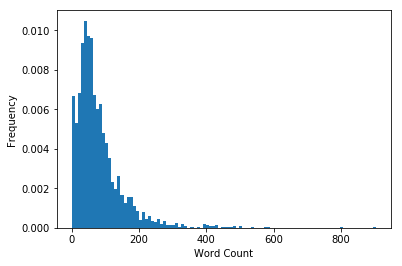

In [192]:
plt.hist(wordCountList_np, bins =100, normed=True)
plt.xlabel('Word Count')
plt.ylabel('Frequency')

The histogram seems to a mixture of three Gaussian distributions, with means around 50, 170, and 400.  
Build a 3-component Gaussian Mixture Model below:

Average Word Count by GMM component:
            0
0  143.378893
1  354.649351
2   47.600904


Percentage of requests fulfilled by GMM component:
          0
0  0.342561
1  0.376623
2  0.208592


# of requests by GMM component:
      0
0   578
1    77
2  1769


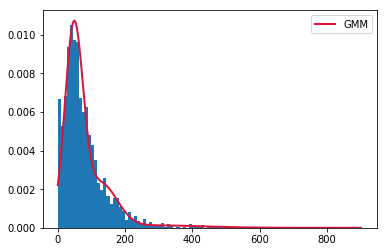

In [193]:
gmm = GaussianMixture(random_state=0, n_components=3)
gmm.fit(wordCountList_np.reshape(-1, 1))

wordCountCategory = gmm.predict(wordCountList_np.reshape(-1, 1))

wordCount_byWordCountCategory = pd.DataFrame(wordCountList).groupby(wordCountCategory).mean()
print('Average Word Count by GMM component:')
print(wordCount_byWordCountCategory)
print('\n')

Y_byWordCountCategory = pd.DataFrame(Y_train_np).groupby(wordCountCategory).mean()
print('Percentage of requests fulfilled by GMM component:')
print(Y_byWordCountCategory)
print('\n')

n_byWordCountCategory = pd.DataFrame(Y_train_np).groupby(wordCountCategory).count()
print('# of requests by GMM component:')
print(n_byWordCountCategory)

gmm_x = np.linspace(0, 900, 901)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

plt.hist(wordCountList_np, bins = 100, normed=True)
plt.plot(gmm_x, gmm_y, color="crimson", lw=2, label="GMM")
plt.legend()

Based on the average word count by GMM component, we label Component 0-2 as medium, high, and low word count category respectively. Medium and high word count requests have much higher chance of getting fulfilled than low word count requests. However, there are only 77 requests in the training set that's classified as high word count and the likelihood of receiving a pizza is not significantly different for high word count requests from medium word count requests. To avoid overfitting, we decide to group medium and high word count together.

In [194]:
wordCountCategoryGrp_List = []
for i in range(len(wordCountCategory)):
    if (wordCountCategory[i]==0) or (wordCountCategory[i]==1):
        wordCountCategoryGrp_List.append(1)
    else:
        wordCountCategoryGrp_List.append(0)

Y_byWordCountCategory = pd.DataFrame(Y_train_np).groupby(wordCountCategoryGrp_List).mean()
print('Percentage of requests fulfilled by GMM component (after grouping):')
print(Y_byWordCountCategory)
print('\n')

n_byWordCountCategory = pd.DataFrame(Y_train_np).groupby(wordCountCategoryGrp_List).count()
print('# of requests by GMM component (after grouping):')
print(n_byWordCountCategory)

Percentage of requests fulfilled by GMM component (after grouping):
          0
0  0.208592
1  0.346565


# of requests by GMM component (after grouping):
      0
0  1769
1   655


### Building Textual Features

Now, we add these features to our output dataset

In [195]:
def add_text_features(input_df, output_df):    
    # Combine the title and text into one
    input_df['post_and_title'] = input_df['request_text_edit_aware'] + ' ' + input_df['request_title']
    
    # Pre-process the data
    clean_text = input_df['post_and_title'].apply(lambda s: pre_process(s))
    
    # Construct the narrative
    for n in narratives:
        output_df[str('topic_' + str(n[0]))] = clean_text.apply(lambda s: find_narrative(n,s))
        
    # Check if user indicated in text about giving back to community in some way
    output_df['reciprocity'] = input_df['post_and_title'].apply(
        lambda x:1 if re.search("repay|pay.+back|pay.+forward|return.+favor|favour", x) else 0)

    # Check if there is an image in the text or not
    output_df['image_in_text'] = input_df['post_and_title'].str.contains(
        'imgur.com|.jpg|.png|.jpeg|http', case = False).apply(lambda x: 1 if x else 0)
    
    # Check if a user is polite
    output_df['politeness'] = input_df['post_and_title'].apply(
        lambda x: 1 if re.search("thank|appreciate|advance", x) else 0)
    
    
    request_text_edit_aware_np = input_df['request_text_edit_aware'].values
    stateAbbrList = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]
    otherExlcusionList = ['US', 'PS', 'EDIT', 'PM']

    capCategoryList = []
    sid = SentimentIntensityAnalyzer()
    compoundSenList = []

    ## Count the number of words in a request text
    wordCountList = []

    for i in range(len(request_text_edit_aware_np)):
        msg = request_text_edit_aware_np[i]
        ss = sid.polarity_scores(msg)
        compoundSenList.append(ss['compound'])
        wordCountList.append(len(re.findall(r'\w+', msg)))
        
        ## Remove special characters
        msg = re.sub('[^1-9a-zA-Z\s]+', '', msg)
        capCount = 0
        for word in msg.split():
            ## Remove if a word has only 1 character (i.e., 'I')
            if len(word) > 1:
                if word.isupper() and word not in stateAbbrList and word not in otherExlcusionList:
                    capCount += 1
        if capCount == 0:
            capCategory = 0
        else:
            capCategory = 1

        capCategoryList.append(capCategory)

    
    wordCountList_np = np.asarray(wordCountList)
    wordCountCategory = gmm.predict(wordCountList_np.reshape(-1, 1))
    wordCountCategoryGrp_List = []
    for i in range(len(wordCountCategory)):
        if (wordCountCategory[i]==0) or (wordCountCategory[i]==1):
            wordCountCategoryGrp_List.append(1)
        else:
            wordCountCategoryGrp_List.append(0)

    output_df['capCategory'] = capCategoryList
    output_df['compoundSen'] = compoundSenList
    output_df['wordCountCategory'] = wordCountCategoryGrp_List
    
    return output_df

In [196]:
train_feat_mat = add_text_features(input_df = train_df,
                                   output_df = train_feat_mat)
dev_feat_mat = add_text_features(input_df = dev_df,
                                 output_df = dev_feat_mat)
test_feat_mat = add_text_features(input_df = test_df,
                                  output_df = test_feat_mat)

### Dimensionality Reduction

Below, we get the top 66 coefficients from our Logistic Regression which correspond to our most influential words according to the model.

In [197]:
def bow_vectorizer():
    vectorizer = TfidfVectorizer(min_df = 5,
                                 ngram_range = (1,2), 
                                 preprocessor = pre_process,
                                 stop_words = 'english',
                                 norm = 'l2',
                                 sublinear_tf = True)

    train_bag_of_words = vectorizer.fit_transform(train_df['post_and_title'])
    dev_bag_of_words = vectorizer.transform(dev_df['post_and_title'])
    test_bag_of_words = vectorizer.transform(test_df['post_and_title'])
    
    feature_names = vectorizer.vocabulary_
    
    return (train_bag_of_words, dev_bag_of_words, test_bag_of_words, feature_names)

In [198]:
def pruned_bow(train_bag_of_words, dev_bag_of_words, test_bag_of_words):
    lr = LogisticRegression(C = 1,
                            penalty = 'l1').fit(train_bag_of_words, train_labels)
    model = SelectFromModel(lr, prefit=True)
    
    features_selected = model.get_support()

    train_pruned_bag_of_words = model.transform(train_bag_of_words)
    dev_pruned_bag_of_words = model.transform(dev_bag_of_words)
    test_pruned_bag_of_words = model.transform(test_bag_of_words)

    return (train_pruned_bag_of_words, dev_pruned_bag_of_words, test_pruned_bag_of_words, features_selected)

In [199]:
train_bag_of_words, dev_bag_of_words, test_bag_of_words, feature_names = bow_vectorizer()
train_pruned_bag_of_words, dev_pruned_bag_of_words, test_pruned_bag_of_words, features_selected = pruned_bow(train_bag_of_words, 
                                                                                                             dev_bag_of_words,
                                                                                                             test_bag_of_words)

print(train_bag_of_words.shape)
print(train_pruned_bag_of_words.shape)
print(dev_bag_of_words.shape)
print(dev_pruned_bag_of_words.shape)
print(test_bag_of_words.shape)
print(test_pruned_bag_of_words.shape)

(2424, 4017)
(2424, 67)
(1616, 4017)
(1616, 67)
(1631, 4017)
(1631, 67)


In [200]:
# Extract column headers from feature lists
feature_sorted_list = []
for elem in sorted(feature_names.items()):
    feature_sorted_list.append(elem[0])
    
feature_labels_selected = []
for i in range(len(feature_sorted_list)):
    if features_selected[i] == True:
        feature_labels_selected.append(feature_sorted_list[i])
        
train_pruned_text_df_final = pd.DataFrame(train_pruned_bag_of_words.toarray(),
                                          columns = feature_labels_selected)
dev_pruned_text_df_final = pd.DataFrame(dev_pruned_bag_of_words.toarray(),
                                       columns = feature_labels_selected)
test_pruned_text_df_final = pd.DataFrame(test_pruned_bag_of_words.toarray(),
                                        columns = feature_labels_selected)

### Topic Modeling

Now, we prepare a count matrix so that we can perform topic modeling. We create a topic model of 3 topics accross 3329 words.

In [201]:
def lda_vectorizer():
    vectorizer_lda = CountVectorizer(min_df = 3,
                                     ngram_range = (1,1), 
                                     preprocessor = pre_process,
                                     stop_words = 'english')

    lda_bag_of_words = vectorizer_lda.fit_transform(train_df['post_and_title'])
    lda_dev_bag_of_words = vectorizer_lda.transform(dev_df['post_and_title'])
    lda_test_bag_of_words = vectorizer_lda.transform(test_df['post_and_title'])

    return (lda_bag_of_words, lda_dev_bag_of_words, lda_test_bag_of_words)

In [202]:
def lda_topics(lda_bag_of_words, lda_dev_bag_of_words, lda_test_bag_of_words):
    lda = LatentDirichletAllocation(n_components = 3, 
              learning_method='batch',
              max_iter=30,
              learning_decay=.7, 
              random_state=42)

    train_topics = lda.fit_transform(lda_bag_of_words)
    dev_topics = lda.transform(lda_dev_bag_of_words)
    test_topics = lda.transform(lda_test_bag_of_words)

    return (train_topics, dev_topics, test_topics)

In [203]:
lda_bag_of_words, lda_dev_bag_of_words, lda_test_bag_of_words = lda_vectorizer()

train_topics, dev_topics, test_topics = lda_topics(lda_bag_of_words, lda_dev_bag_of_words, lda_test_bag_of_words)

train_topics_df = pd.DataFrame({'topic1':train_topics[:,0], 'topic2':train_topics[:,1], 'topic3':train_topics[:,2]})
dev_topics_df = pd.DataFrame({'topic1':dev_topics[:,0], 'topic2':dev_topics[:,1], 'topic3':dev_topics[:,2]})
test_topics_df = pd.DataFrame({'topic1':test_topics[:,0], 'topic2':test_topics[:,1], 'topic3':test_topics[:,2]})

Next, we also generate 3 topics using NMF matrix factorization.

In [204]:
def tfidf_vectorizer():
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.95, 
        min_df=2, 
        stop_words='english')

    train_tfidf = tfidf_vectorizer.fit_transform(train_df['post_and_title'])
    dev_tfidf = tfidf_vectorizer.transform(dev_df['post_and_title'])
    test_tfidf = tfidf_vectorizer.transform(test_df['post_and_title'])
    
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    return (train_tfidf, dev_tfidf, test_tfidf)

In [205]:
def nmf_topics(train_tfidf, dev_tfidf, test_tfidf):
    no_topics = 3

    # Run NMF
    nmf_model = NMF(n_components=no_topics, 
                    random_state=1, 
                    alpha=.1, 
                    l1_ratio=.5, 
                    init='nndsvd').fit(train_tfidf)

    nmf_train = nmf_model.transform(train_tfidf)
    nmf_dev = nmf_model.transform(dev_tfidf)
    nmf_test = nmf_model.transform(test_tfidf)
    
    return (nmf_train, nmf_dev, nmf_test)

In [206]:
train_tfidf, dev_tfidf, test_tfidf = tfidf_vectorizer()

nmf_train, nmf_dev, nmf_test = nmf_topics(train_tfidf, dev_tfidf, test_tfidf)

nmf_train_df = pd.DataFrame({'nmf1':nmf_train[:,0], 'nmf2':nmf_train[:,1], 'nmf3':nmf_train[:,2]})
nmf_dev_df = pd.DataFrame({'nmf1':nmf_dev[:,0], 'nmf2':nmf_dev[:,1], 'nmf3':nmf_dev[:,2]})
nmf_test_df = pd.DataFrame({'nmf1':nmf_test[:,0], 'nmf2':nmf_test[:,1], 'nmf3':nmf_test[:,2]})

### Combine All Features for Final Modeling

In [207]:
train_combined = pd.concat([train_feat_mat,
                           train_pruned_text_df_final,
                           train_topics_df, 
                           nmf_train_df], 
                           axis = 1)

dev_combined = pd.concat([dev_feat_mat,
                         dev_pruned_text_df_final,
                         dev_topics_df, 
                         nmf_dev_df],
                        axis = 1)

test_combined = pd.concat([test_feat_mat,
                           test_pruned_text_df_final,
                           test_topics_df, 
                           nmf_test_df],
                          axis = 1)

<a id="models"></a>  
## 6. Models

Following our featuring engineering, we will now re-run our 3 key models again on the master combined datset.

<a id="mnb"></a>
### 6.1 Naive Bayes Model

For the final model we will transition from a multinomial Naive Bayes algorithm to Bernoulli. given that we have created many more binary features now, we can limit the main table to remove continuous variables. Bernoulli is much more applicable here given the binary outcome variable. We again will optimize the `alpha` parameter for smoothing.

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.4s finished


Best Alpha parameter: 10.0
AUC score = 0.641 

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1218
           1       0.39      0.26      0.31       398

   micro avg       0.72      0.72      0.72      1616
   macro avg       0.59      0.56      0.57      1616
weighted avg       0.69      0.72      0.70      1616



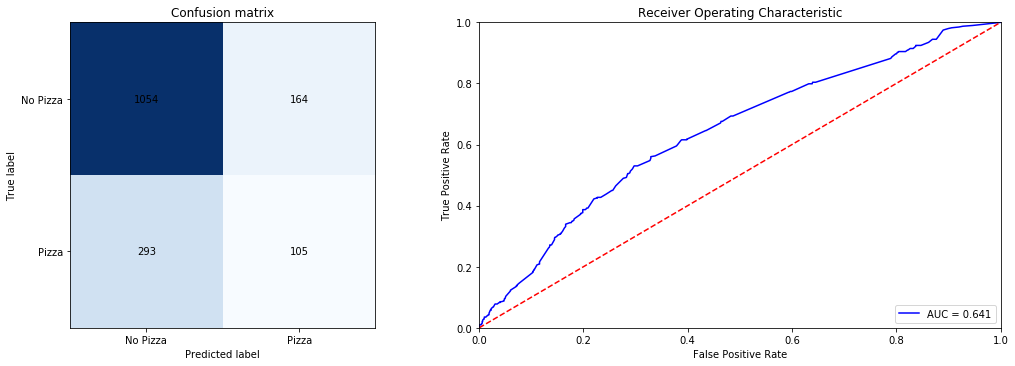

Best Parameters
{'alpha': 10.0}


In [208]:
# BERNOULLI W/ BINARY
train_combined_binary = train_combined.select_dtypes(include=['int'])
dev_combined_binary = dev_combined.select_dtypes(include=['int'])

class_priors = [1-(np.sum(train_labels) / len(train_labels)),
                 np.sum(train_labels) / len(train_labels)]

# Create BernoulliNB
bnb = BernoulliNB(class_prior = class_priors)
alpha_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

# Use GridSearchCV to find the best value for alpha 
bnb_final_cv = GridSearchCV(bnb, 
                            alpha_params, 
                            scoring = "roc_auc",
                            return_train_score = True,
                            n_jobs = -1, 
                            cv = kfold, 
                            verbose = 1)
bnb_final_cv.fit(train_combined_binary, train_labels)

print('Best Alpha parameter: ' + str(bnb_final_cv.best_params_['alpha']))
dev_pred_bnb_final = bnb_final_cv.predict(dev_combined_binary)
dev_prob_bnb_final = bnb_final_cv.predict_proba(dev_combined_binary)[:,1]

standard_output(labels_in = dev_labels, 
                pred_prob_in = dev_prob_bnb_final, 
                pred_class_in = dev_pred_bnb_final)

print("Best Parameters")
print(bnb_final_cv.best_params_)

**Result:** Much improved AUC from baseline of 0.62 but this model appears to be too conservative, missing many fulfilled requests. This creates a sligtly higher accuracy by virtue of more frequently predicting the majority class but is not sensitive enough to fulfilled requests. The Pizza precision and recall are both very low for this model.

<a id="mlr"></a>
### 6.2 Logistic Regression Model

 - Logistic Regression
        * `solver` - Will seek to find the optimal solver given the data size and feature dentiy (newton-cg, lbfgs, liblinear, sag, or saga)
        * `penalty` - Select norm for penalization (l1 or l2)
        * `C` - Adjust to reduce overfitting
        * `tol` & `max_iter` - Deal with convergence issues
    - Naive Bayes (BernoulliNB)
        * `alpha` - Adjust smoothing for issues with sparse data
    - Decision Trees / Random Forest

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.8s finished


AUC score = 0.668 

              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1218
           1       0.51      0.13      0.21       398

   micro avg       0.76      0.76      0.76      1616
   macro avg       0.64      0.55      0.53      1616
weighted avg       0.71      0.76      0.70      1616



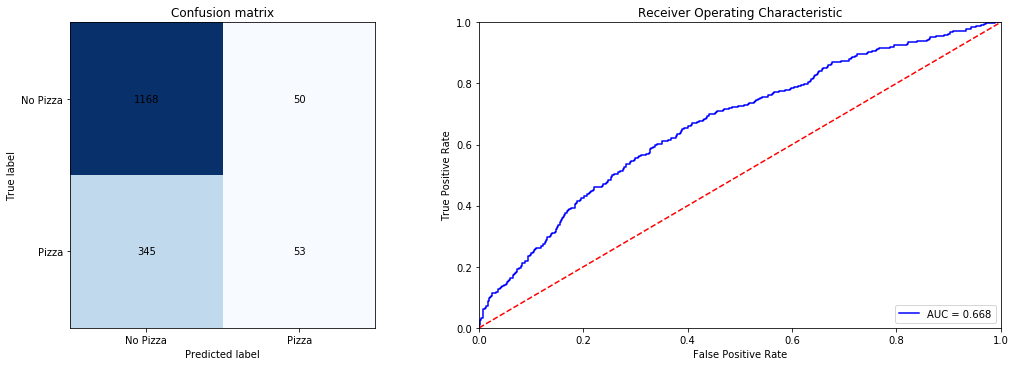

Best Parameters
{'C': 5.0}


In [209]:
logitreg = LogisticRegression(penalty = 'l2', solver = 'liblinear', max_iter = 1000, multi_class = 'auto')

# GridSearchCV over range of values of 'C' to find optimal value
c_params = {'C': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 2.0, 5.0, 10.0]}
logitreg_cv_final = GridSearchCV(logitreg, 
                                 c_params, 
                                 scoring = "roc_auc",
                                 return_train_score = True,
                                 n_jobs = -1, 
                                 cv = kfold, 
                                 verbose = 1)
logitreg_cv_final.fit(train_combined, train_labels)

dev_pred_logitreg_final = logitreg_cv_final.predict(dev_combined)
dev_prob_logitreg_final = logitreg_cv_final.predict_proba(dev_combined)[:,1]

standard_output(labels_in = dev_labels, 
                pred_prob_in = dev_prob_logitreg_final, 
                pred_class_in = dev_pred_logitreg_final)

print("Best Parameters")
print(logitreg_cv_final.best_params_)

**Result:** As with Naive Bayes, the logistic regression has improved AUC from baseline given the new features but it is still too conservative. The predicted Pizza class implies a rate of  6.6%, much lower than the actual fulfillment rate of ~25%. Of the predicted Pizza requests, they were split roughly 50/50 between True Pizza and No Pizza requests, which is an improvement in precision from the Naive Bayes model but is still far too low and has shown no improvement in recall.

### 6.3 XGBoost Model

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.6min finished


AUC score = 0.683 

              precision    recall  f1-score   support

           0       0.84      0.68      0.75      1218
           1       0.38      0.59      0.46       398

   micro avg       0.66      0.66      0.66      1616
   macro avg       0.61      0.64      0.61      1616
weighted avg       0.72      0.66      0.68      1616



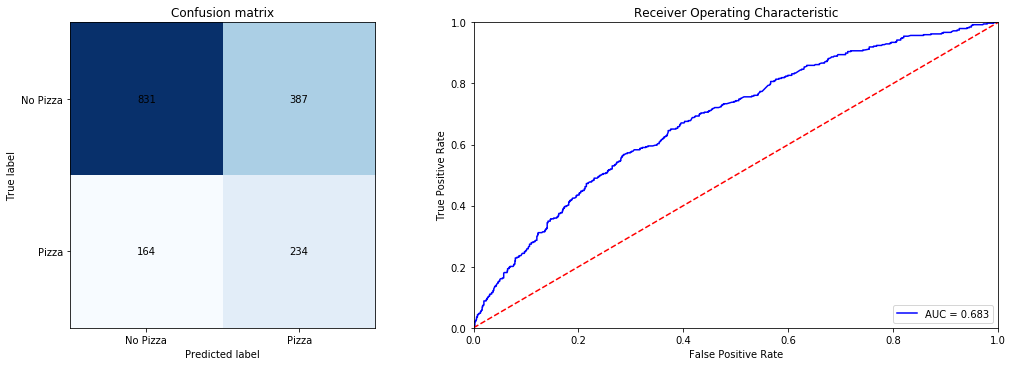

Best Parameters
{'max_depth': 2, 'n_estimators': 50}


In [211]:
# Base Model
# https://xgboost.readthedocs.io/en/latest/parameter.html
local_pos = (len(train_labels) - np.sum(train_labels)) / np.sum(train_labels)

xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc',
                             scale_pos_weight = local_pos)

# Parameters to test
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]

xgb_param_grid = dict(max_depth = max_depth, n_estimators = n_estimators)

# Grid search
grid_search_xgb = GridSearchCV(xgb_model, 
                               xgb_param_grid, 
                               scoring = "roc_auc",
                               return_train_score = True,
                               n_jobs = -1, 
                               cv = kfold, 
                               verbose = 1)
grid_result_xgb = grid_search_xgb.fit(train_combined, train_labels)

# Predict
dev_pred_xgb_final = grid_result_xgb.predict(dev_combined)
dev_prob_xgb_final = grid_result_xgb.predict_proba(dev_combined)[:, 1]

standard_output(labels_in = dev_labels, 
                pred_prob_in = dev_prob_xgb_final, 
                pred_class_in = dev_pred_xgb_final)

print("Best Parameters")
print(grid_result_xgb.best_params_)

**Result:** This is the first model that actually achieves a modest improvement in Pizza recall, though it does sacrifice some precision. Given that this is the only model to achieve >50% recall on both classes and has the highest AUC, this appers to be the strongest model and therefore will be the basis for our final test submission.

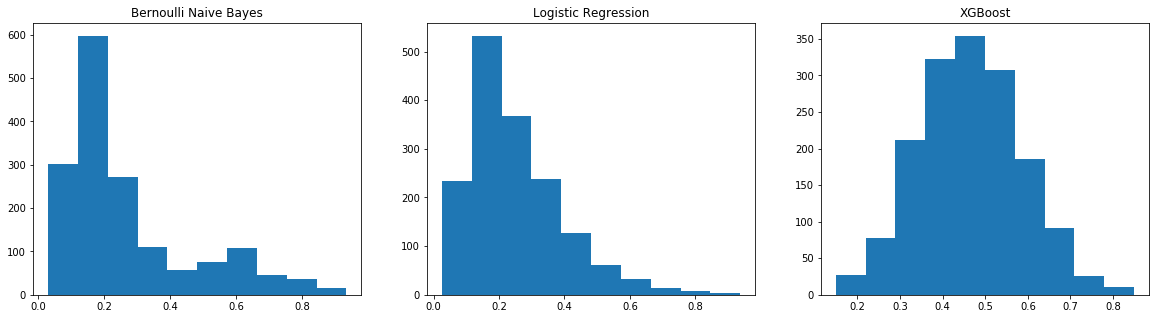

In [212]:
# Histograms of predicted probabilities
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.hist(dev_prob_bnb_final)
plt.title("Bernoulli Naive Bayes")

plt.subplot(1,3,2)
plt.hist(dev_prob_logitreg_final)
plt.title("Logistic Regression")

plt.subplot(1,3,3)
plt.hist(dev_prob_xgb_final)
plt.title("XGBoost")

plt.show()

<a id="error"></a>  
## 7. Error Analysis

For the first part of the error analysis, we take a look at whether the feature values are statistifically significantly different between the correct prediction and incorrect prediction. Ideally, XGBoost prediction should account for all signals in the features and thus the feature values should NOT be statistically significantly different between the correct and incorrect prediction.

In [213]:
correctDev = dev_combined[dev_pred_xgb_final==dev_labels]
incorrectDev = dev_combined[dev_pred_xgb_final!=dev_labels]

columnList_DevCombined = []
ttest_p_DevCombined = []
mean_correct_DevCombined = []
mean_incorrect_DevCombined = []
for column in correctDev:
    columnList_DevCombined.append(column)
    mean_correct_DevCombined.append(correctDev[column].mean())
    mean_incorrect_DevCombined.append(incorrectDev[column].mean())
    t_ttest, p_ttest = stat.ttest_ind(correctDev[column],incorrectDev[column])
    ttest_p_DevCombined.append(p_ttest)
    
## Reference on converting list to DataFrame: https://thispointer.com/python-pandas-how-to-convert-lists-to-a-dataframe/
t_test_pd = pd.DataFrame(list(zip(columnList_DevCombined, mean_correct_DevCombined, mean_incorrect_DevCombined, ttest_p_DevCombined)), columns=['Feature Name', 'Mean for Correct Prediction', 'Mean for Incorrect Prediction', 'p-value for t-test'])

## Only print the significant variables
print(t_test_pd[t_test_pd['p-value for t-test']  < 0.01])
print('\n')
print('There are %i features with significantly different means.' %t_test_pd[t_test_pd['p-value for t-test']  < 0.01].shape[0])

                                         Feature Name  \
2   requester_days_since_first_post_on_raop_at_req...   
4                               during_initial_period   
5                                       monthExpDecay   
6                                                 new   
7                                           throwaway   
8                                     first_requester   
9                                      never_comments   
10                                            popular   
13                                      topic_college   
15                                       topic_friend   
21                                  wordCountCategory   
24                                                ask   
55                                                ive   
69                                              pizza   
73                                            request   
76                                               stay   
82                             

There are 22 features with significantly different means (with p-value less than 0.01). For example, the average number of days between requesters first post on RAOP and this request is 24 for misclassified requests and 14 for correctly classified requests. This means the misclassification rate is higher for repeat requesters compared to first-time requesters. We should look into those 22 features to see whether we can better engineer those features to make sure signals are appropriately captured by the model. 

The second part of the error analysis is to see whether there is any feature that we missed in the feature engineering but can be predictive (i.e., has significantly different misclassification rates).  

In [214]:
pd.DataFrame(Y_train_np).groupby(dev_df['account_age_cat']).mean()

,0
account_age_cat,
new,0.277778
old,0.248013
throwaway,0.224090


As shown in the table above, throwaway accounts have lowest fulfillment rates. This is possibly because that people may consider the requests from throwaway accounts to be less genuine. The t-test above shows a significantly higher misclassification rate for a throwaway account. So there may be some heterogeneity among throwaway accounts that cannot be easily distinguished by a throwaway account indicator.

In [215]:
misclassified_index_dev = np.where(dev_labels != dev_pred_xgb_final)

errorAnalysis_dev = dev_df.iloc[misclassified_index_dev]
errorAnalysis_dev_labels = dev_labels[misclassified_index_dev]

## If the request text or title contains 'throwaway' or 'throw away', make it as self-identified throwaway accounts
ind_selfIdentified_throwaway_lst = []
for i in range(len(errorAnalysis_dev)):
    msg = errorAnalysis_dev['post_and_title'].values[i]
    if 'throwaway' in msg or 'throw away' in msg:
        ind_selfIdentified_throwaway_lst.append(1)
    else:
        ind_selfIdentified_throwaway_lst.append(0)

errorAnalysis_dev['ind_selfIdentified_throwaway'] = ind_selfIdentified_throwaway_lst
selfIdentified_index_dev = np.where(errorAnalysis_dev['ind_selfIdentified_throwaway'] == 1)

## Print the correct label for self-identified throwaway accounts
print(errorAnalysis_dev_labels[selfIdentified_index_dev])

[1 1 1 0 1]


After reviewing the misclassified requests, we notice 4 out of 5 requesters who acknowledge throwaway accounts actually received pizzas. If we included a "self-identified throwaway account" indicator in our feature list, we would be able to improve our model. 

<a id="conclusion"></a>  
# 8. Results / Conclusion


Final Model Parameters
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=50, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=3.0671140939597317, seed=None,
       silent=True, subsample=1)


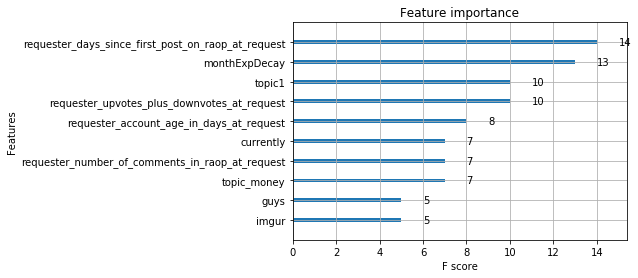

In [216]:
print("Final Model Parameters")
xgb_final = grid_search_xgb.best_estimator_
print(xgb_final)
xgb.plot_importance(xgb_final,
                    max_num_features = 10)

In [217]:
# Final test predicition
test_pred_xgb_final = grid_result_xgb.predict(test_combined).astype(int)

# Submission file
result_dict = {'request_id': test_df.request_id, 
               'requester_received_pizza': test_pred_xgb_final}
submission_df = pd.DataFrame(data = result_dict)
submission_df.set_index('request_id', inplace = True)
print(submission_df.shape)
submission_df.to_csv('submission.csv')

(1631, 1)


Final model predictions submitted to Kaggle, resulting auc: **0.63986**  

Our model is less accurate than the baseline ZeroR method of simply guessing the highest likelihood class. However, the value of this model is a much cleaner, separable estimation of likelihood, and thereby a substantially higher AUC. Given the imbalanced classes and the subjectivity of the underlying process we are trying to model, the consistently low AUC scores throughout these modeling exercises indicates that this may be an inherently difficult classification problem but this is still an informative model. A test AUC score of 0.63986 is above average in the Kaggle competition.